# 初步分析

一共86个案例，其中自变量21个，因变量18个。

,Treatment,PP1,PP6,PP7,PP8,PP9,PP10,PP11,PP12,PP13,...,O14,O15,O16,O17,O18,PP2,PP3,PP4,PP5,
54,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,2
26,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,2
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,4
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,6,30,30,72


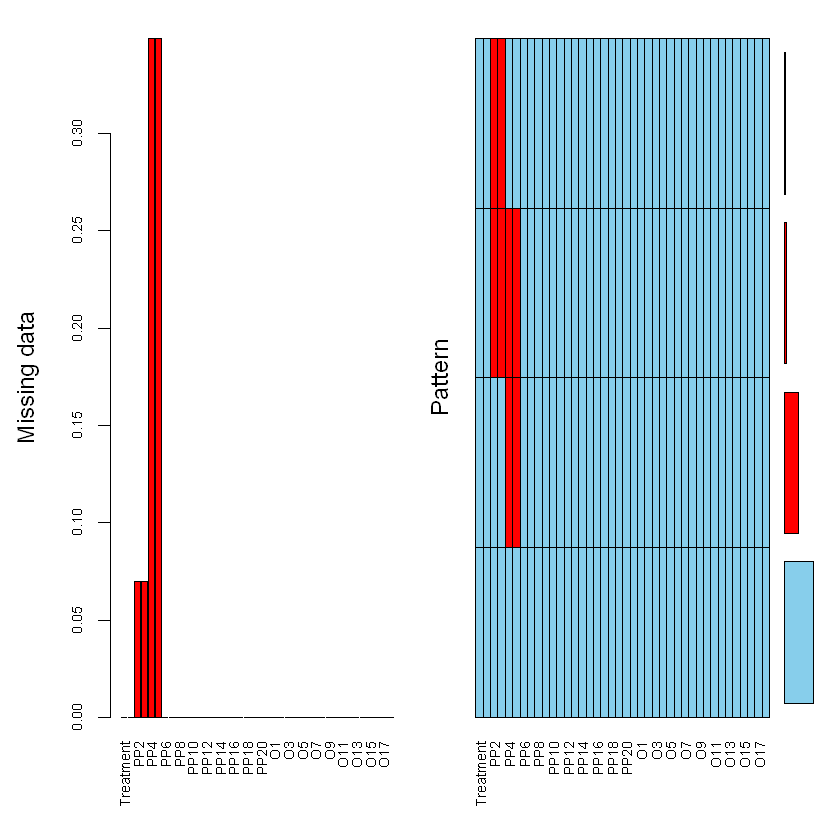

In [1]:
powder <- read.csv("powder.csv")
rownames(powder) <- powder$Treatment
predictors.index <- grep("PP", colnames(powder),value=T)
responses.index <- grep("O", colnames(powder),value=T)
powder.scaled<-powder 
powder.scaled[-1]<-scale(powder[-1]) # normalized data
#sort(apply(powder.scaled[-1], 2, function(col) e1071::skewness(col, na.rm = TRUE))) #查看skew程度
mice::md.pattern(powder) # 查看数据缺失情况
mice_plot <- VIM::aggr(powder,
                    labels=names(powder), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))

In [2]:
print(na.index<-unique(which(is.na(powder),arr.ind = T)[,1]))

 [1] 51 57 58 71 83 84 53 54 56 59 60 61 62 63 64 66 67 68 69 70 72 73 74 76 77
[26] 78 79 80 81 82 85 86


以上可以看到整个数据的缺失情况。在86个案例中，有54个完整，32个有缺失。其中`PP2`和`PP3`各有6个缺失；`PP4`和`PP5`各有30个缺失。

## 变量之间的相关性
看看所有变量（自变量加响应变量）的相关矩阵图

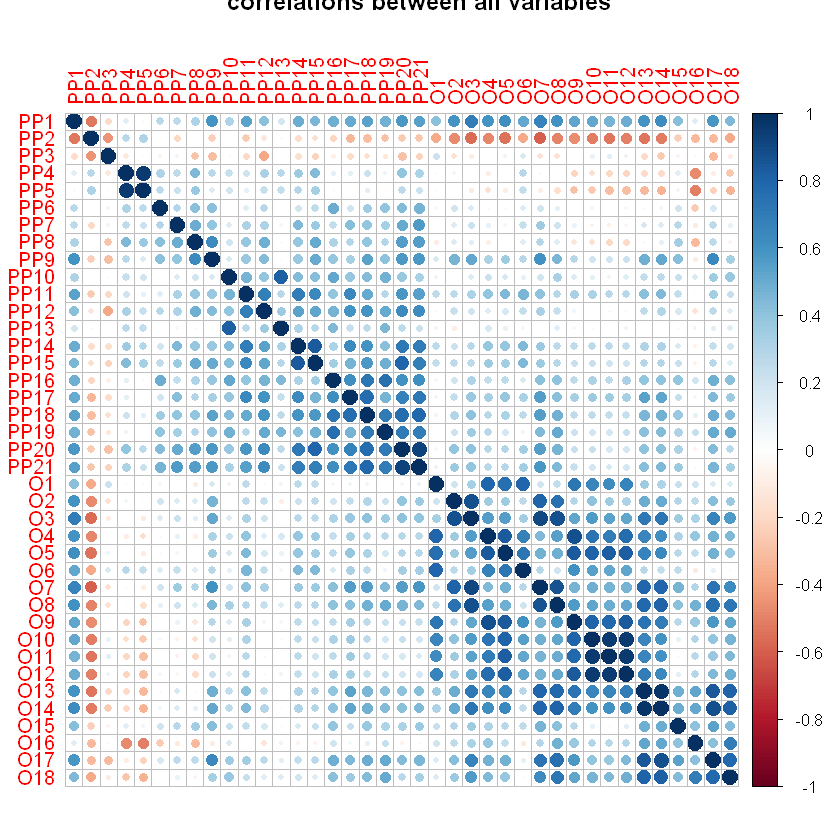

In [3]:
correlations <- list("predictors" = cor(powder[predictors.index],use = "complete"),
                  "responses" = cor(powder[responses.index], use = "all.obs"),
                  "all" = cor(powder[-1], use = "complete"))
corrplot::corrplot(correlations[["all"]], order = "original",
                   main = "correlations between all variables")

自变量和因变量很明显地分为两块，这说明许多自变量之间相关性很高（物理属性比较相近），而许多因变量之间相关性也很高（污渍类别比较接近）；但从反对角块来看，大部分自变量与因变量之间的相关性并不强。

### 响应变量之间的相关性
先看看响应变量的相关矩阵图：

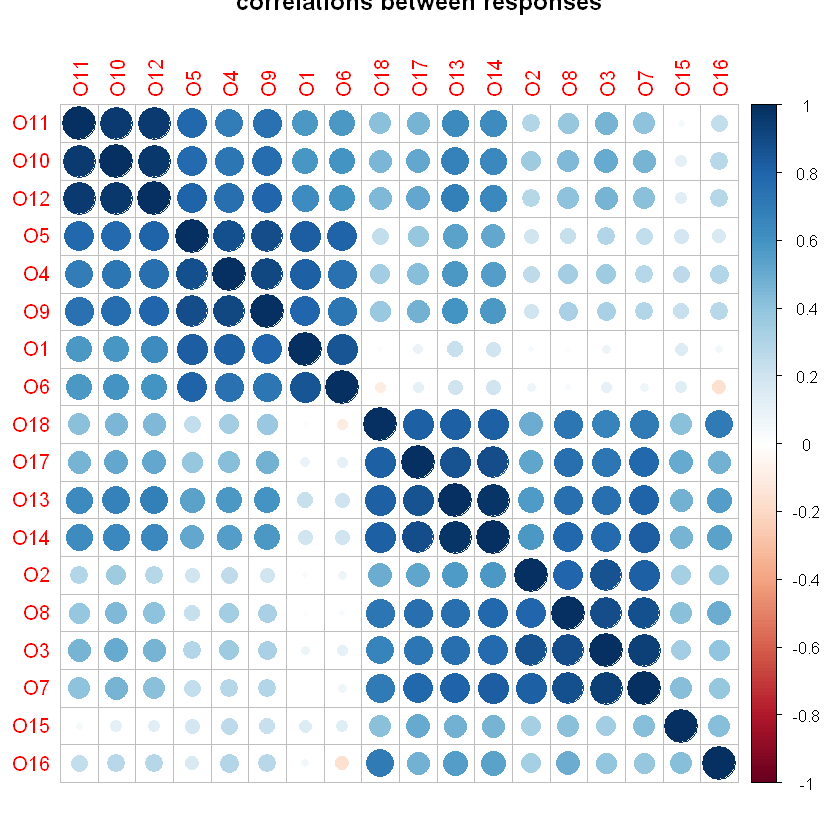

In [4]:
corrplot::corrplot(correlations[["responses"]], order = "hclust",
                   main = "correlations between responses")

再用主成分分析（PCA）来看一看：（用标准化后的数据）

[1] 0.53886004 0.22794400 0.06511166 0.05770125 0.03256965 0.02144202

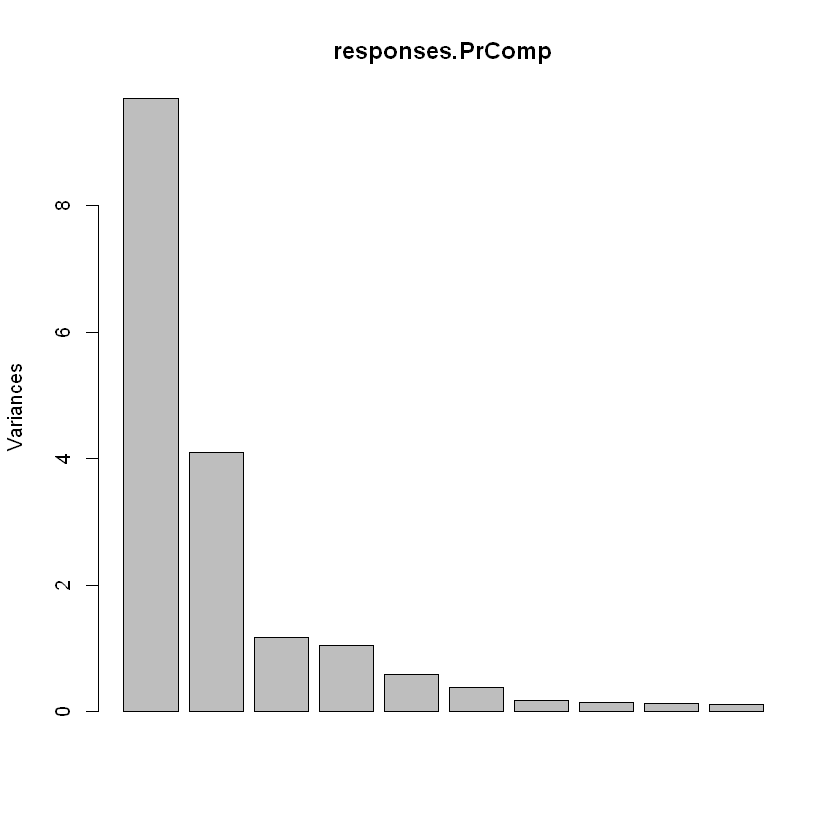

In [5]:
## responses 的PCA
responses.PrComp <- prcomp(powder[responses.index], center = TRUE, scale. = TRUE)
plot(responses.PrComp)
head(responses.PrComp$sd ^ 2 / sum(responses.PrComp$sd ^ 2))

前两个主成分占了变异性的大部分。

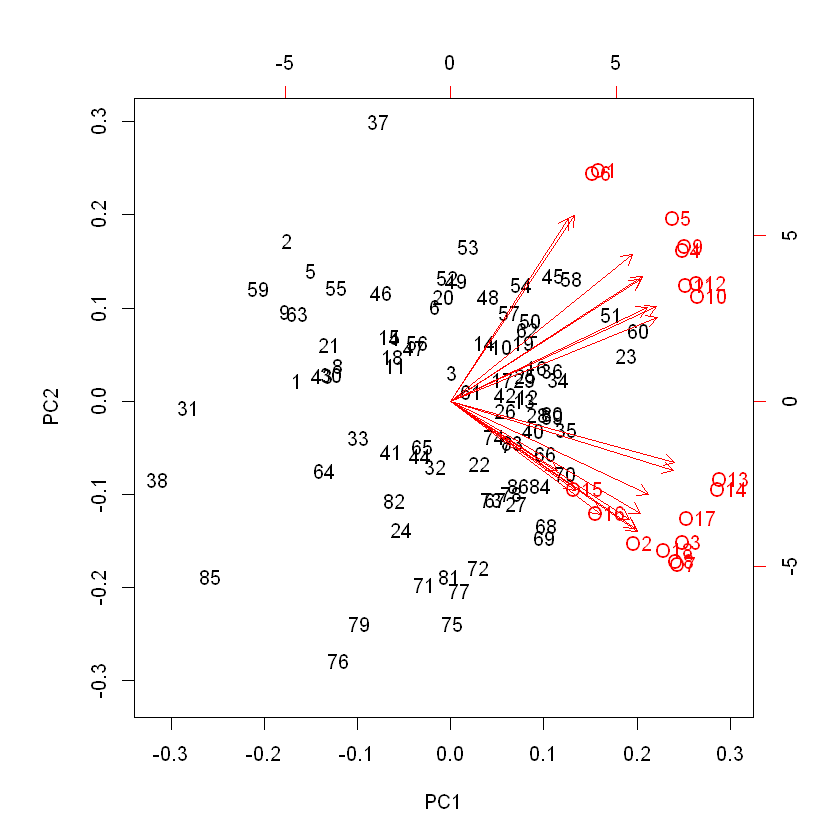

In [6]:
biplot(responses.PrComp)

从前两个主成分的图上来看，响应变量主要分为两类。

用因子分析（factor analysis）并选取 `factors=2`：

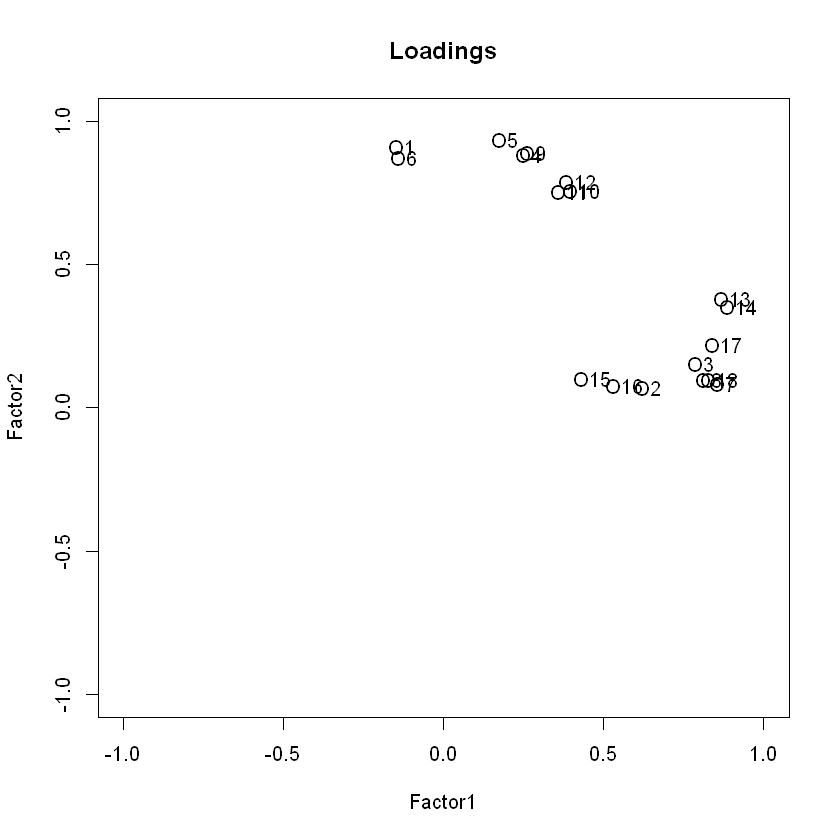

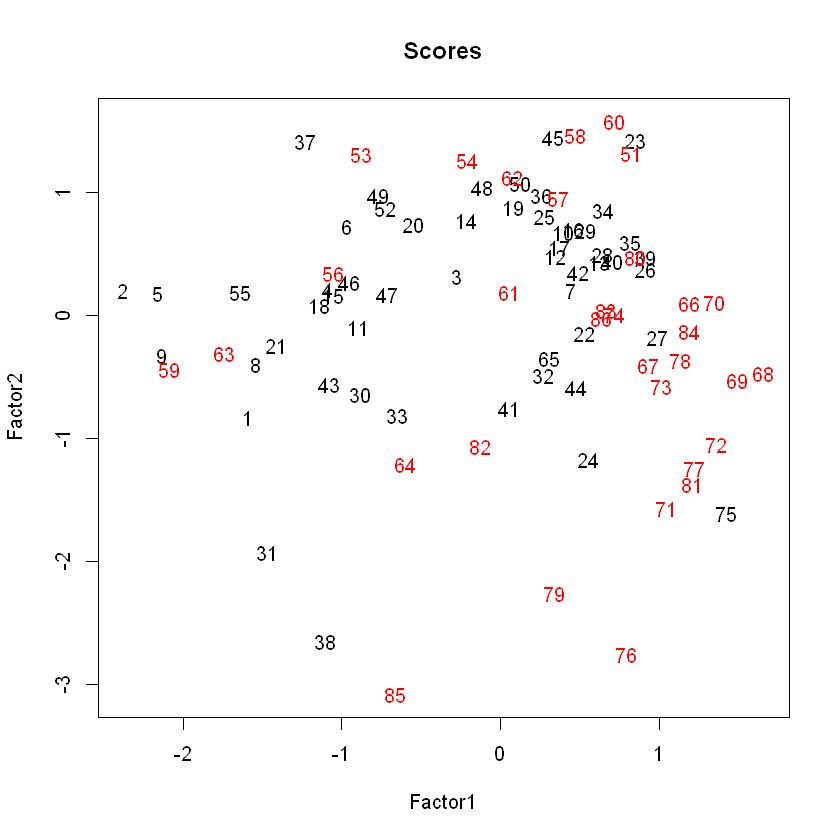

In [7]:
# responses 的 factor analysis
responses.factanal <- factanal(powder.scaled[responses.index], factors = 2, scores = "regression")
plot(responses.factanal$loadings[, 1:2], type = "n", main = "Loadings",
     xlim = c(-1, 1), ylim = c(-1, 1))
text(responses.factanal$loadings[, 1], responses.factanal$loadings[, 2],
     labels = row.names(responses.factanal$loadings))
plot(responses.factanal$scores[, 1:2], type = "n", main = "Scores")
na.col<-rep("black",nrow(powder))
na.col[na.index]<-"red"
text(responses.factanal$scores[,1],responses.factanal$scores[,2],labels=1:86,col=na.col)

因子分析给出和主成分分析相似的建议——都指向将响应变量分为两类，或许分别对应两类污渍，比如“溶于水”、“不溶于水”。此外，在这张图中含有缺失的案例分布得比较均匀，没有什么明显得pattern，这说明我们应该可以用常规的MAR假设下得填补方法处理缺失数据。

此外，在这张图上，我们还将有缺失的案例用红色标出，我们看到缺失似乎与factor1体现出一定的正相关，即我们有理由怀疑这不是完全随机缺失（MCAR）

### 响应变量的分类与降维

相关矩阵、主成分分析和因子分析，都指向把响应变量分为以下两类：
+ 污渍1：`[O1, O4, O5, O6, O9, O10, O11, O12]`
+ 污渍2：`[O2, O3, O7, O8, O13, O14, O15, O16, O17, O18]`

进一步查看刚刚因子分析的结果：

In [8]:
responses.factanal


Call:
factanal(x = powder.scaled[responses.index], factors = 2, scores = "regression")

Uniquenesses:
   O1    O2    O3    O4    O5    O6    O7    O8    O9   O10   O11   O12   O13 
0.152 0.588 0.330 0.147 0.088 0.224 0.231 0.301 0.126 0.242 0.274 0.204 0.039 
  O14   O15   O16   O17   O18 
0.029 0.774 0.676 0.190 0.251 

Loadings:
    Factor1 Factor2
O1  -0.131   0.911 
O2   0.638         
O3   0.804   0.154 
O4   0.266   0.884 
O5   0.193   0.935 
O6  -0.124   0.872 
O7   0.873         
O8   0.830         
O9   0.281   0.892 
O10  0.428   0.758 
O11  0.392   0.757 
O12  0.416   0.789 
O13  0.902   0.382 
O14  0.920   0.354 
O15  0.464   0.103 
O16  0.564         
O17  0.872   0.223 
O18  0.860         

               Factor1 Factor2
SS loadings      6.927   6.208
Proportion Var   0.385   0.345
Cumulative Var   0.385   0.730

Test of the hypothesis that 2 factors are sufficient.
The chi square statistic is 676.08 on 118 degrees of freedom.
The p-value is 3.81e-79 

前两个因子解释了73%的方差。所以我们考虑将18个响应变量降至两个，可以采用因子分析的`scores`；或者主成分分析的前两个主成分`PC1`和`PC2`。

In [9]:
powder.scaled[c('factor1','factor2')]<-responses.factanal$scores
powder.scaled[c('PC1','PC2')]<-responses.PrComp$x[,1:2]
powder.scaled

Treatment,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,O13,O14,O15,O16,O17,O18,factor1,factor2,PC1,PC2
1,-0.839025303,1.39146301,0.07625361,1.32378599,1.87486315,-0.35645854,0.33930445,-1.86326461,-1.05674444,...,-1.7402514,-2.01569945,-3.0898452021,-0.97242824,-2.16119759,-0.78514627,-1.58551217,-0.83058688,-4.74974222,0.423757462
2,-0.989392899,0.33386692,1.18356672,0.54105272,0.69730584,-0.71291709,0.38121610,0.03633900,-0.49137150,...,-1.8803293,-2.34078671,-1.3632744621,-0.76447873,-2.10804482,-1.97202807,-2.37140875,0.20530819,-5.05193788,3.232087627
3,-0.065074440,-0.98644413,1.31443099,0.88480309,1.09035753,0.74559245,1.23234505,1.87727263,2.23460879,...,-0.1112888,-0.24848743,-0.0869726393,-1.09940626,0.28791880,0.02396317,-0.27477978,0.32144542,0.06475507,0.572567552
4,-0.980547746,1.68785937,1.23389913,0.24165725,0.56548972,-0.53468781,-1.87234124,-3.47864476,-0.89280730,...,-0.8785000,-1.04819102,-0.0642972262,-0.37986414,-0.88144228,-0.35239958,-1.08457618,0.21379562,-1.72134522,1.277075822
5,-2.205969946,1.49924351,1.69695734,1.34857255,1.75383199,-0.30893074,-1.80786177,-1.21919859,-1.56221727,...,-1.7476760,-2.22227108,-1.5414384221,-0.74791638,-1.92814311,-1.56606375,-2.15626642,0.17757476,-4.31003913,2.640477517
6,0.086767348,0.15872362,-0.42203729,-1.71452365,-2.12515685,-0.52874684,-1.51125623,-1.66117912,-1.61686298,...,-0.7701005,-0.56083703,-1.2790514992,1.75851934,-0.86236180,-0.98249004,-0.96661755,0.72724152,-0.46397933,1.920110841
7,1.801989880,-0.06357365,0.03598768,0.82283670,1.00647455,0.51389440,-0.05402030,1.75341379,1.52001103,...,0.2010404,0.51300318,2.0477555365,-0.75711768,1.73394689,0.57652572,0.44594566,0.20473759,1.74931033,-0.875731867
8,0.407035586,0.63699956,-1.15689054,1.06417946,1.25492796,0.36834049,0.37154418,1.66214937,1.72703421,...,-1.6447212,-1.76260766,0.8232832293,-1.71773402,-0.86099891,-1.75917872,-1.53685178,-0.39423762,-3.48433839,0.710880433
9,-0.750573776,1.51945235,-0.51766888,0.96438097,1.41909894,0.18417025,-0.52472040,0.69213902,-0.61222259,...,-2.2386912,-2.21174866,-1.6645335218,-1.20246089,-1.64875031,-1.90577694,-2.13130651,-0.31910473,-5.13637303,1.807726794
10,0.972019716,0.56963675,-2.13837261,0.76217487,1.02764502,0.19902269,-2.01742004,0.06241455,-0.04264614,...,0.9964652,0.73120485,0.9690537421,0.65252237,-0.31311644,0.37354356,0.39436485,0.67497045,1.57622729,1.100031819


在后续研究中，我们重点研究`factor1`和`factor2`这两个响应变量。

### 区分训练集和测试集
再进一步研究自变量之前，我们应该将数据分为训练集和测试集，并在最终预测前将测试集严格置于“黑盒子”中。按照作业要求，我们取前10个样本作为训练集。

In [10]:
powder.scaled.test<-head(powder.scaled,10)
powder.scaled.train<-powder.scaled[-c(1:10),]
powder.train<-head(powder,10)
powder.test<-powder[-c(1:10),]

### 自变量之间的相关性
我们再来看看自变量之间的相关矩阵图（按照hierachical聚类排序，由于自变量中数据有缺失，暂时先考虑完全数据）：

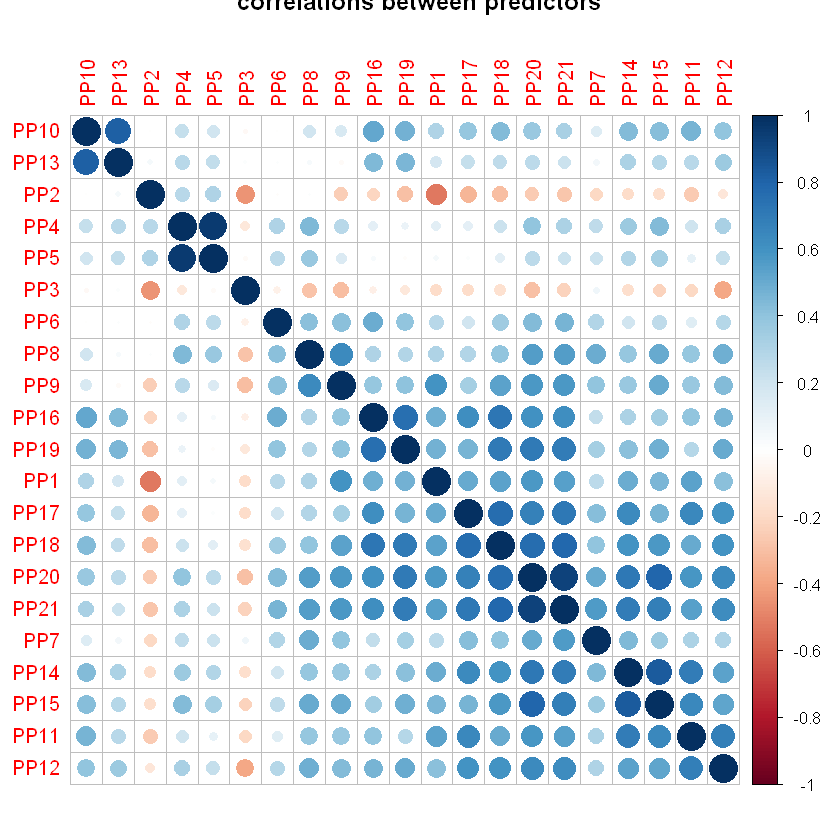

In [11]:
corrplot::corrplot(correlations[["predictors"]], order = "hclust",
                   main = "correlations between predictors")

再看看PCA：

[1] 0.41118194 0.12531308 0.09513481 0.06979692 0.06522116 0.04376541

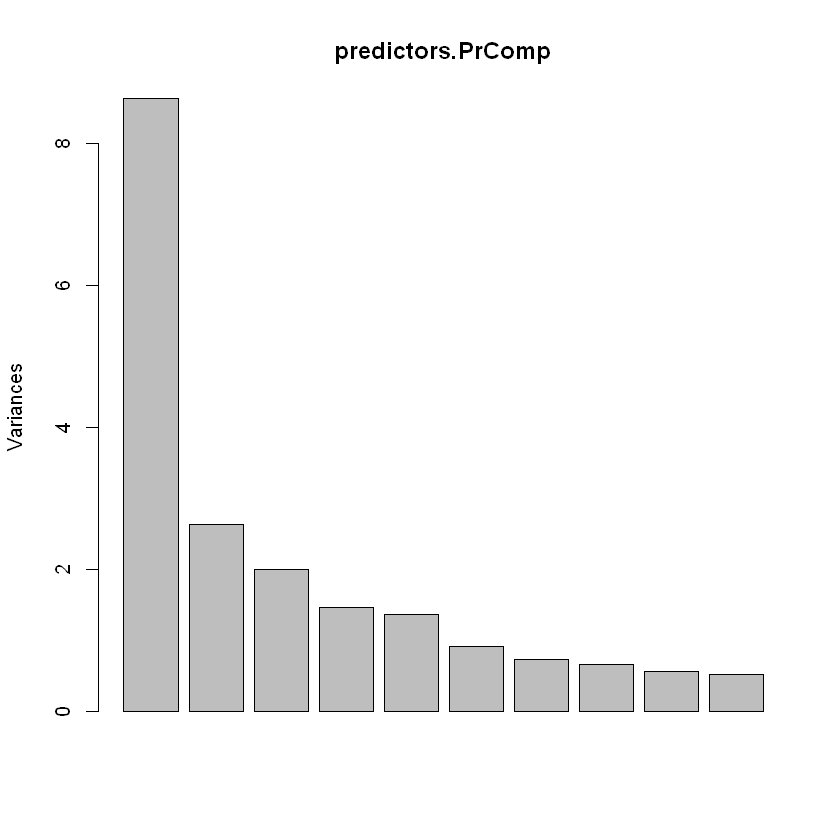

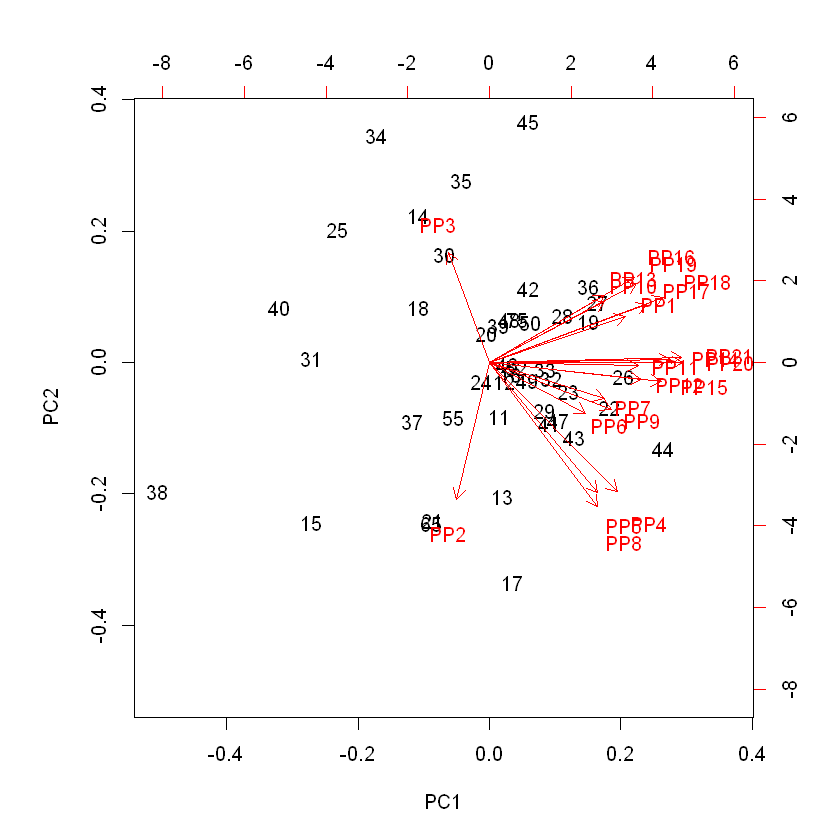

In [12]:
predictors.PrComp <- prcomp(na.omit(powder.scaled.train[predictors.index]), center = TRUE, scale. = TRUE)
plot(predictors.PrComp)
head(predictors.PrComp$sd ^ 2 / sum(predictors.PrComp$sd ^ 2))
biplot(predictors.PrComp)

与其他自变量相比，`PP2`和`PP3`分别代表一种很不同的属性；`PP4`和`PP5`很接近，与其他属性不同；其余属性比较相似。

### 自变量共线性
在拟合模型之前，需要考虑自变量的共线性问题。可以看看设计矩阵的条件数$\kappa$，以及共线性的指标“VIF”：

In [13]:
OLS.colin<-lm(reformulate(grep("PP", names(powder), value = T),
                       response = "factor1"), powder.scaled.train, na.action = na.omit)
kappa(OLS.colin)
head(sort(car::vif(OLS.colin),decreasing = T))

[1] 32.14689

PP4      PP5     PP20     PP21     PP14     PP19 
27.77456 26.01310 22.91786 20.45543 11.75215 10.67965

设计矩阵的条件数并不小，这警示我们如果用全模型直接线性拟合会有严重的共线性问题。从各个自变量的VIF值中，`PP4`、`PP5`、`PP20`、`PP21`的值很大，这从之前的相关矩阵图中已经可以看出来了。

### 典型变量分析（CCA）

Multiple Outcomes 的情形特别适合用典型变量分析，“CCA” (canonical correlation analysis)，即分别在$\mathbf{X}$和$\mathbf{Y}$中各自找一个代表，即各自变量的线性组合$\mathbf{X} v_m$和$\mathbf{Y} u_m$使得相关系数：
\begin{equation}
  \mathrm{Corr}^2(\mathbf{Y} u_m, \mathbf{X} v_m)
\end{equation}
达到最大。

In [138]:
# powder.scaled.cc.CCA <- CCA::cc(
#     powder.scaled.train[complete.cases(powder.scaled), predictors.index],
#     powder.scaled.train[complete.cases(powder.scaled), responses.index])
# powder.scaled.cc.CCA$cor
# with(powder.scaled.cc.CCA,
#      biplot(cbind(scores$xscores[,1],scores$xscores[,2]),cbind(xcoef[,1],xcoef[,2])))
# with(powder.scaled.cc.CCA,
#      biplot(cbind(scores$yscores[,1],scores$yscores[,2]),cbind(ycoef[,1],ycoef[,2])))
# powder.scaled.cc.CCA

## 缺失数据填补

在进一步拟合模型之前，还有一个重要的问题——缺失数据的处理。将缺失数据所在行直接扔掉的做法是难以接受的：即使MCAR（缺失与结果无关）的假设成立，在样本量已经如此小的情况下也会导致丢失太多信息。所以考虑对缺失数据作填补（imputation）。

众所周知，填补的方法不胜枚举，分别有不同的假设，适应不同的场合。这里主要考虑用“pmm”（predictive mean matching），做多重填补，最后取多个填补后的数据的推断和预测的平均。

In [66]:
# library(mice)
# pred_matrix<- 1 - diag(1, ncol(powder.scaled.train))
# pred_matrix[,1]<-0
# pred_matrix[,(1+length(predictors.index)+1):ncol(powder.scaled.train)]<- 0
# powder.imputed.pmm<-mice(powder.scaled.train,predictorMatrix = pred_matrix ,maxit = 50, method = "pmm", seed = 500, printFlag = F)
# summary(powder.imputed.pmm)

In [67]:
# powder.imputed.pmm$imp$PP2 # 查看填补的值，多重填补，填补了五次

In [68]:
# fit<-with(data=powder.imputed.pmm, exp=lm(reformulate(grep("PP", names(powder), value = T),
#                                                       response = "Cluster1")))
# combine<-pool(fit)
# summary(combine)

In [69]:
# powder.imputed.pmm.2 <- complete(powder.imputed.pmm,2)

### KNN Impute
第二种方法填补方法是“k-nearest neighbors”

In [14]:
powder.imputed.knn <- powder.scaled.train[predictors.index]
powder.imputed.knn<-t(impute::impute.knn(t(powder.scaled.train[predictors.index]))[['data']])
tail(powder.imputed.knn)

,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,PP10,...,PP12,PP13,PP14,PP15,PP16,PP17,PP18,PP19,PP20,PP21
81,0.4925387,-0.8045645,-0.3062727,1.2432637,1.2432637,0.7129171,0.3586483,-0.24788446,-0.4220135,1.15936828,...,2.0896224,0.05645367,1.15177432,1.4892168,1.2257843,1.7615687,2.0759756,-0.02695504,0.36708273,0.2624062
82,0.2422946,0.5022739,0.8765390,0.1313113,0.1313113,-0.5406288,-0.5086005,-0.20355603,-0.3831310,0.04832188,...,0.1609793,-0.25388859,0.01618618,0.5729247,0.9035433,0.8510057,0.7808467,-0.59738579,-1.56767938,-1.0031000
83,-0.4667918,0.1039439,0.4385650,0.4395125,0.4395125,-0.5138944,-1.6079754,0.02982012,-0.1687516,0.98135533,...,0.9820848,-0.34856928,-0.03509845,0.6076327,1.1861239,1.4669748,1.3624914,0.67698078,-0.19414598,0.3230292
84,0.1719019,0.1977186,0.4596904,0.5876713,0.5876713,-0.6208320,0.2522572,-0.01059698,-0.5470681,0.53325374,...,1.1539441,-0.42220981,-0.26954245,0.2466692,1.1117606,1.5406232,1.4788204,0.54954412,-0.06860798,-0.3210907
85,-1.4537634,-0.5351133,0.7507080,0.2274169,0.2274169,1.0099659,0.7971087,0.53307818,-0.9421986,-0.43047160,...,0.9820848,-0.62735130,-0.26221608,-0.6765645,-1.0546910,0.6568416,0.7498257,-1.71397365,-1.64890985,-1.0334115
86,-0.4450475,-0.3532337,0.6601096,0.4115617,0.4115617,-0.8436186,0.7132853,-0.49038705,-0.7036491,-0.02533865,...,0.8102255,0.37205596,-0.60655571,-0.1142944,0.7151562,1.5272326,1.6571914,0.43424429,0.02000708,-0.1467994


### （非条件）均值填补

In [15]:
# 因为X已经中心化了，所以填补0
powder.imputed.mean<-powder.scaled.train[predictors.index]
for (PP in paste("PP",2:5,sep="")){
    powder.imputed.mean[is.na(powder.imputed.mean[PP]),PP]<-0
}
tail(powder.imputed.mean)

,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,PP10,...,PP12,PP13,PP14,PP15,PP16,PP17,PP18,PP19,PP20,PP21
81,0.4925387,-0.8045645,-0.3062727,0,0,0.7129171,0.3586483,-0.24788446,-0.4220135,1.15936828,...,2.0896224,0.05645367,1.15177432,1.4892168,1.2257843,1.7615687,2.0759756,-0.02695504,0.36708273,0.2624062
82,0.2422946,0.5022739,0.8765390,0,0,-0.5406288,-0.5086005,-0.20355603,-0.3831310,0.04832188,...,0.1609793,-0.25388859,0.01618618,0.5729247,0.9035433,0.8510057,0.7808467,-0.59738579,-1.56767938,-1.0031000
83,-0.4667918,0.0000000,0.0000000,0,0,-0.5138944,-1.6079754,0.02982012,-0.1687516,0.98135533,...,0.9820848,-0.34856928,-0.03509845,0.6076327,1.1861239,1.4669748,1.3624914,0.67698078,-0.19414598,0.3230292
84,0.1719019,0.0000000,0.0000000,0,0,-0.6208320,0.2522572,-0.01059698,-0.5470681,0.53325374,...,1.1539441,-0.42220981,-0.26954245,0.2466692,1.1117606,1.5406232,1.4788204,0.54954412,-0.06860798,-0.3210907
85,-1.4537634,-0.5351133,0.7507080,0,0,1.0099659,0.7971087,0.53307818,-0.9421986,-0.43047160,...,0.9820848,-0.62735130,-0.26221608,-0.6765645,-1.0546910,0.6568416,0.7498257,-1.71397365,-1.64890985,-1.0334115
86,-0.4450475,-0.3532337,0.6601096,0,0,-0.8436186,0.7132853,-0.49038705,-0.7036491,-0.02533865,...,0.8102255,0.37205596,-0.60655571,-0.1142944,0.7151562,1.5272326,1.6571914,0.43424429,0.02000708,-0.1467994


### 条件均值填补（线性回归）

In [16]:
powder.imputed.reg<-powder.scaled.train[predictors.index]
PP4.impute.reg<-lm(PP4~.-PP2-PP3-PP5 , data=powder.scaled.train[predictors.index],subset = complete.cases(PP4))
# powder.scaled.train$PP4[which(is.na(powder.scaled.train$PP4))]
# which(is.na(powder.scaled.train$PP4))
powder.imputed.reg$PP4[which(is.na(powder.scaled.train$PP4))]<- predict(
    PP4.impute.reg,newdata=powder.scaled.train[which(is.na(powder.scaled.train$PP4)),predictors.index])

PP5.impute.reg<-lm(PP5~.-PP2-PP3-PP4 , data=powder.scaled.train[predictors.index],subset = complete.cases(PP5))
powder.imputed.reg$PP5[which(is.na(powder.scaled.train$PP5))]<- predict(
    PP5.impute.reg,newdata=powder.scaled.train[which(is.na(powder.scaled.train$PP5)),predictors.index])
PP2.impute.reg<-lm(PP2~.-PP3-PP5-PP4 , data=powder.scaled.train[predictors.index],subset = complete.cases(PP2))
powder.imputed.reg$PP2[which(is.na(powder.scaled.train$PP2))]<- predict(
    PP2.impute.reg,newdata=powder.scaled.train[which(is.na(powder.scaled.train$PP2)),predictors.index])
PP3.impute.reg<-lm(PP3~.-PP2-PP5-PP4 , data=powder.scaled.train[predictors.index],subset = complete.cases(PP3))
powder.imputed.reg$PP3[which(is.na(powder.scaled.train$PP3))]<- predict(
    PP3.impute.reg,newdata=powder.scaled.train[which(is.na(powder.scaled.train$PP3)),predictors.index])

为简明起见，后续的分析统一采用中心化、标准化、knn填补后的数据，即`powder.imputed.knn`。

响应变量统一采用降维后得到的`Cluster1`和`Cluster2`。

之后我们会看到，通过CV评价，在各种方法下`knn.impute`的表现都不错。

# 建立统计模型

## 评价标准：10-fold CV MSE
由于样本量小，选择了10-fold CV的RMSE（或MSE）作为评价预测能力好坏的指标。

package`caret`中的`train`函数可以很方便地整合、对比不同方法的训练和预测结果。比如，我们采取对所有自变量的简单线性回归：

In [20]:
library(caret)
library(e1071)
library(MASS)
library(RANN)

k<-10
set.seed(1)
index<-createFolds(powder.scaled.train$Treatment,k=k,returnTrain = TRUE)
repeats<- 5
X<-powder.imputed.reg
y<-powder.scaled.train$factor1 # 响应函数函数
trControl<-trainControl(method = "cv",number = k, index = index)
sd(y)

[1] 0.8900541

### Ordinary Least Square

In [21]:
OLS_knn <- train(x = powder.imputed.knn,y=y,
             #preProcess="pca",
             method = "lm",
             trControl = trControl)
OLS <- train(x = powder.imputed.reg,y=y,
             #preProcess="pca",
             method = "lm",
             trControl = trControl)
OLS_mean <- train(x = powder.imputed.mean,y=y,
             #preProcess="pca",
             method = "lm",
             trControl = trControl)
OLS_knn;OLS;OLS_mean
summary(OLS$finalModel)

Linear Regression 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared 
  0.6777366  0.4894324

Tuning parameter 'intercept' was held constant at a value of TRUE
 

Linear Regression 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE      Rsquared 
  0.657831  0.5342063

Tuning parameter 'intercept' was held constant at a value of TRUE
 

Linear Regression 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared 
  0.6931214  0.4669466

Tuning parameter 'intercept' was held constant at a value of TRUE
 


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.84746 -0.32163  0.06304  0.32345  0.98872 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.040764   0.077183   0.528 0.599564    
PP1          0.115661   0.135583   0.853 0.397391    
PP2         -0.457052   0.137412  -3.326 0.001589 ** 
PP3         -0.493418   0.128812  -3.831 0.000335 ***
PP4          0.354660   0.427724   0.829 0.410653    
PP5         -0.330189   0.451687  -0.731 0.467931    
PP6         -0.086540   0.085696  -1.010 0.317074    
PP7          0.085152   0.087886   0.969 0.336921    
PP8         -0.156722   0.134232  -1.168 0.248120    
PP9          0.210453   0.154258   1.364 0.178133    
PP10         0.361225   0.127497   2.833 0.006466 ** 
PP11        -0.158126   0.158471  -0.998 0.322817    
PP12         0.003543   0.149725   0.024 0.981207    
PP13        -0.283981   0.126063  -2.253 0.028365 *  
PP14        -0.174153   0

In [22]:
OLS.restricted<-train(x = powder.imputed.reg[,paste("PP",c(2,3,9,10,13),sep="")],y=y,
             #preProcess="pca",
             method = "lm",
             trControl = trControl)
# OLS.restricted<-train(x = powder.imputed.reg[,paste("PP",c(9,11,13),sep="")],y=y,
#              #preProcess="pca",
#              method = "lm",
#              trControl = trControl)
OLS.restricted
summary(OLS.restricted$finalModel)
anova(OLS.restricted$finalModel,OLS$finalModel)

Linear Regression 

76 samples
 5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared 
  0.5866794  0.5769596

Tuning parameter 'intercept' was held constant at a value of TRUE
 


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.10852 -0.38915  0.04077  0.40667  0.94798 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.03734    0.06944   0.538    0.592    
PP2         -0.61588    0.08841  -6.966 1.44e-09 ***
PP3         -0.55709    0.09384  -5.936 1.01e-07 ***
PP9          0.12629    0.08016   1.575    0.120    
PP10         0.45000    0.10380   4.335 4.78e-05 ***
PP13        -0.26903    0.10425  -2.580    0.012 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5909 on 70 degrees of freedom
Multiple R-squared:  0.5886,	Adjusted R-squared:  0.5592 
F-statistic: 20.03 on 5 and 70 DF,  p-value: 2.409e-12


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
70,24.44319,NA,NA,NA,NA
54,17.01346,16,7.429737,1.473854,0.1443544


#### 残差诊断

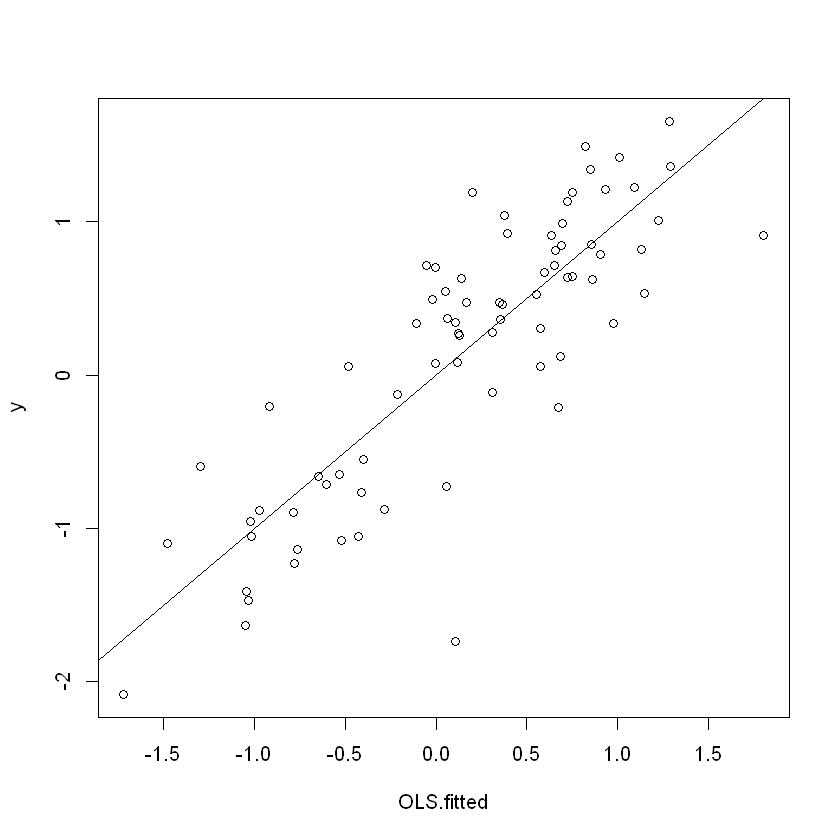

[1] 0.4731398

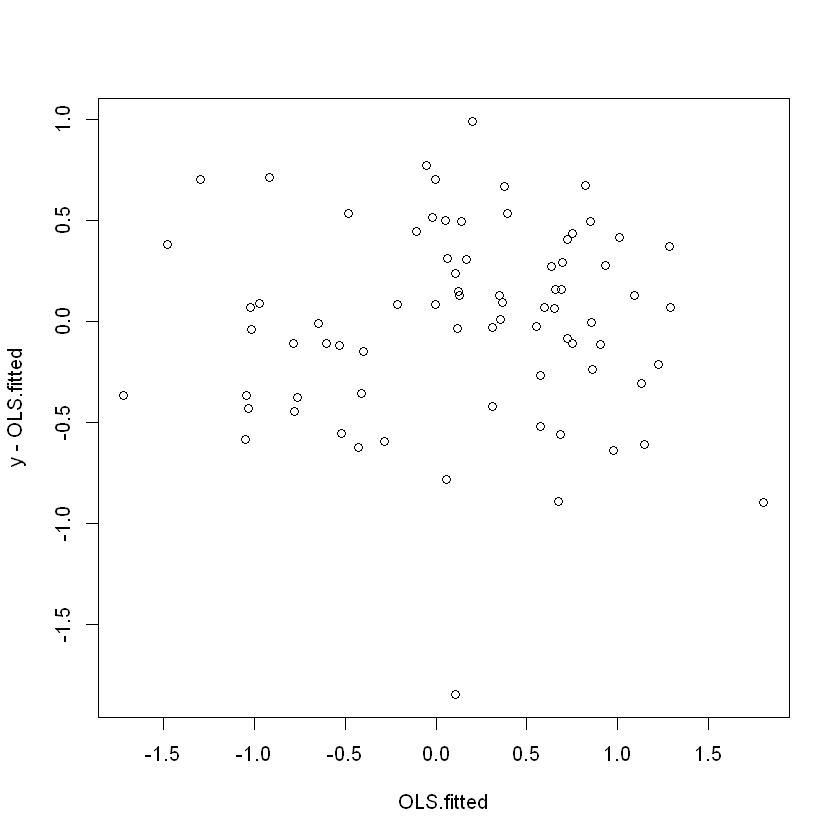

In [23]:
OLS.fitted<-predict(OLS$finalModel,newdata=X[,predictors.index])
plot(OLS.fitted,y)
abline(a = 0, b = 1)
plot(OLS.fitted,y-OLS.fitted) # 残差依然和y高度相关
sqrt(mean((y-OLS.fitted)^2))

### Stepwise Regression

In [24]:
lmStepAIC <- train(x = X, y = y,
                   method = "lmStepAIC",trace=F,
                   #preProcess = "pca",
                   trControl = trControl)
lmStepAIC
summary(lmStepAIC$finalModel)

Linear Regression with Stepwise Selection 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared
  0.6476043  0.511504

 


Call:
lm(formula = .outcome ~ PP2 + PP3 + PP6 + PP9 + PP10 + PP11 + 
    PP13 + PP16, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.75027 -0.27904  0.00902  0.34382  1.33366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.04847    0.06244   0.776 0.440338    
PP2         -0.53447    0.08560  -6.244 3.32e-08 ***
PP3         -0.51969    0.08865  -5.862 1.54e-07 ***
PP6         -0.15320    0.06810  -2.250 0.027758 *  
PP9          0.20536    0.07939   2.587 0.011869 *  
PP10         0.38081    0.10350   3.679 0.000468 ***
PP11        -0.17192    0.07345  -2.341 0.022233 *  
PP13        -0.31637    0.09531  -3.320 0.001461 ** 
PP16         0.29874    0.08059   3.707 0.000428 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5301 on 67 degrees of freedom
Multiple R-squared:  0.6831,	Adjusted R-squared:  0.6453 
F-statistic: 18.05 on 8 and 67 DF,  p-value: 4.725e-14


In [25]:
lmStepBIC <- train(x = X, y = y,
                   method = "lmStepAIC",trace=F,k=log(nrow(X)),
                   #preProcess = "pca",
                   trControl = trControl)
lmStepBIC
summary(lmStepBIC$finalModel)

Linear Regression with Stepwise Selection 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared 
  0.6644794  0.5038216

 


Call:
lm(formula = .outcome ~ PP2 + PP3 + PP6 + PP9 + PP10 + PP11 + 
    PP13 + PP16, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.75027 -0.27904  0.00902  0.34382  1.33366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.04847    0.06244   0.776 0.440338    
PP2         -0.53447    0.08560  -6.244 3.32e-08 ***
PP3         -0.51969    0.08865  -5.862 1.54e-07 ***
PP6         -0.15320    0.06810  -2.250 0.027758 *  
PP9          0.20536    0.07939   2.587 0.011869 *  
PP10         0.38081    0.10350   3.679 0.000468 ***
PP11        -0.17192    0.07345  -2.341 0.022233 *  
PP13        -0.31637    0.09531  -3.320 0.001461 ** 
PP16         0.29874    0.08059   3.707 0.000428 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5301 on 67 degrees of freedom
Multiple R-squared:  0.6831,	Adjusted R-squared:  0.6453 
F-statistic: 18.05 on 8 and 67 DF,  p-value: 4.725e-14


### Lasso

In [27]:
lasso <- train(x = X, y = y,
               method = "lasso",
               #preProcess = "pca",
               tuneLength=10,
               trControl = trControl)
lasso_knn <- train(x = powder.imputed.knn, y = y,
               method = "lasso",
               #preProcess = "pca",
               tuneLength=10,
               trControl = trControl)
lasso_mean <- train(x = powder.imputed.mean, y = y,
               method = "lasso",
               #preProcess = "pca",
               tuneLength=10,
               trControl = trControl)
lasso;

The lasso 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  fraction   RMSE       Rsquared 
  0.1000000  0.7444065  0.2897148
  0.1888889  0.7015711  0.3654956
  0.2777778  0.6642921  0.4534231
  0.3666667  0.6387738  0.5002666
  0.4555556  0.6216709  0.5250539
  0.5444444  0.6117991  0.5474532
  0.6333333  0.6166779  0.5512551
  0.7222222  0.6290299  0.5454848
  0.8111111  0.6396419  0.5437847
  0.9000000  0.6501354  0.5384516

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was fraction = 0.5444444. 

PP3          PP2          PP9         PP10         PP13         PP16 
-0.397736580 -0.378798146  0.260120644  0.255429316 -0.171511293  0.157486521 
         PP8         PP17          PP1         PP11          PP6         PP14 
-0.121721168  0.107717774  0.098738503 -0.094503313 -0.084098379 -0.062110455 
        PP21         PP20         PP18          PP7          PP4          PP5 
-0.018608686 -0.012536249  0.011060732  0.001360218  0.000000000  0.000000000 
        PP12         PP15         PP19 
 0.000000000  0.000000000  0.000000000

PP3        PP2        PP9       PP10       PP13       PP16 
-0.3977366 -0.3787981  0.2601206  0.2554293 -0.1715113  0.1574865

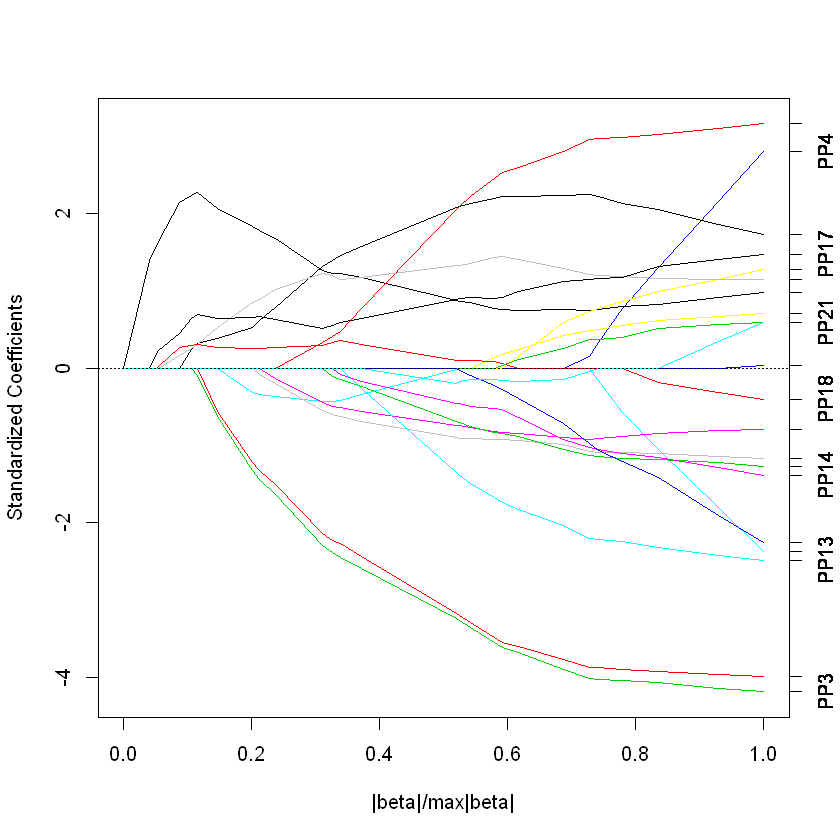

In [28]:
plot(lasso$finalModel,use.color =T)
lasso.finalCoef<-predict(lasso$finalModel,type="coefficients",mode="fraction",s=lasso$bestTune$fraction)$coef
lasso.finalCoef[order(abs(lasso.finalCoef),decreasing = T)]
head(lasso.finalCoef[order(abs(lasso.finalCoef),decreasing = T)])

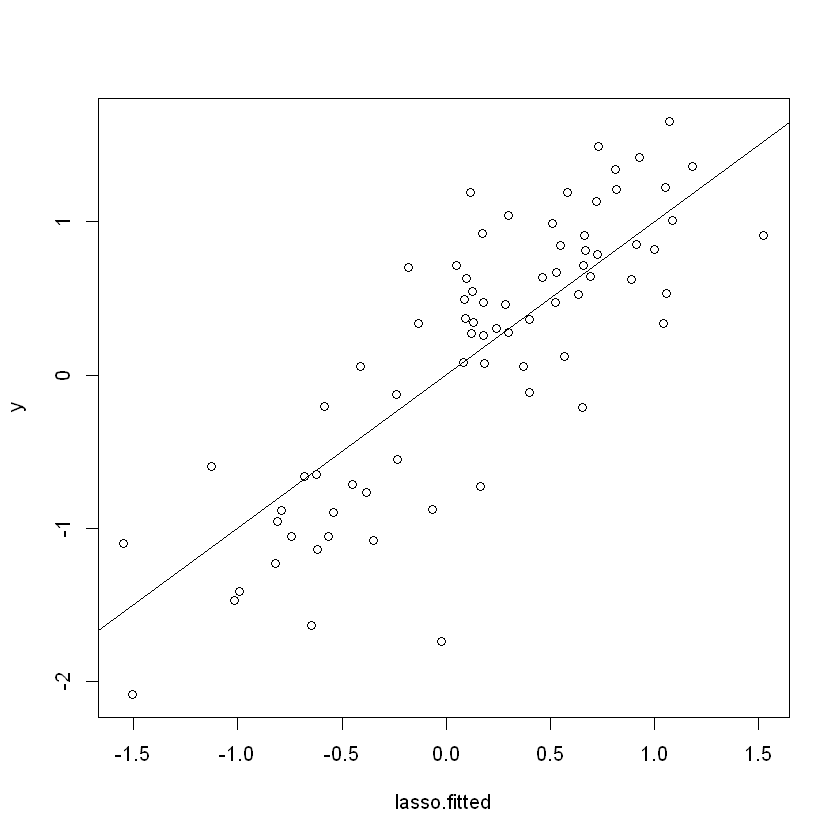

[1] 0.4946056

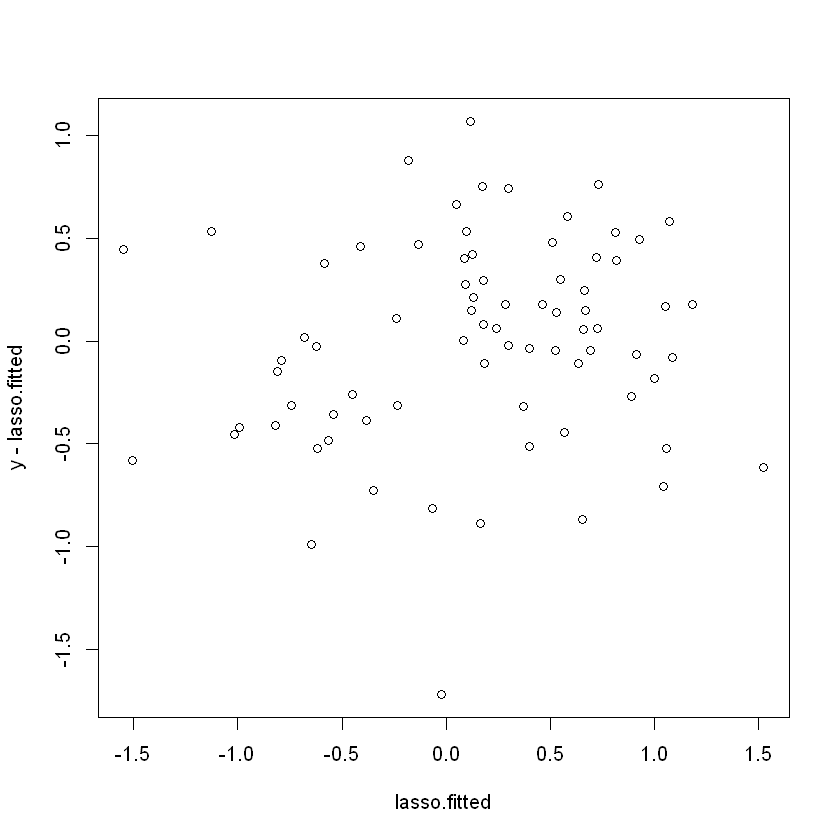

In [29]:
lasso.fitted<-predict(lasso$finalModel,newx=X, mode="fraction",s=lasso$bestTune$fraction)$fit
plot(lasso.fitted,y)
abline(a = 0, b = 1)
plot(lasso.fitted,y-lasso.fitted) # 残差依然和y高度相关
sqrt(mean((y-lasso.fitted)^2))

### Elastic Net

In [30]:
enet <- train(x = X, y = y,
             method = "enet",
             #preProcess = "pca",
             tuneLength=20,
             trControl = trControl)
enet_knn <- train(x = powder.imputed.knn,y=y,
             #preProcess="pca",
             method = "enet",
                  tuneLength=20,
             trControl = trControl)
enet_mean <- train(x = powder.imputed.mean,y=y,
             #preProcess="pca",
             method = "enet",
                   tuneLength=20,
             trControl = trControl)
#enet;enet_knn;enet_mean

PP3          PP2          PP9         PP10         PP13         PP16 
-0.401111381 -0.382145081  0.261340180  0.259469745 -0.174675281  0.159011882 
         PP8         PP17          PP1         PP11          PP6         PP14 
-0.121963591  0.107326233  0.097520042 -0.095876916 -0.084913296 -0.062763180 
        PP21         PP20         PP18          PP7          PP4          PP5 
-0.018556815 -0.014987052  0.010861702  0.003725154  0.000000000  0.000000000 
        PP12         PP15         PP19 
 0.000000000  0.000000000  0.000000000

PP3        PP2        PP9       PP10       PP13       PP16 
-0.4011114 -0.3821451  0.2613402  0.2594697 -0.1746753  0.1590119

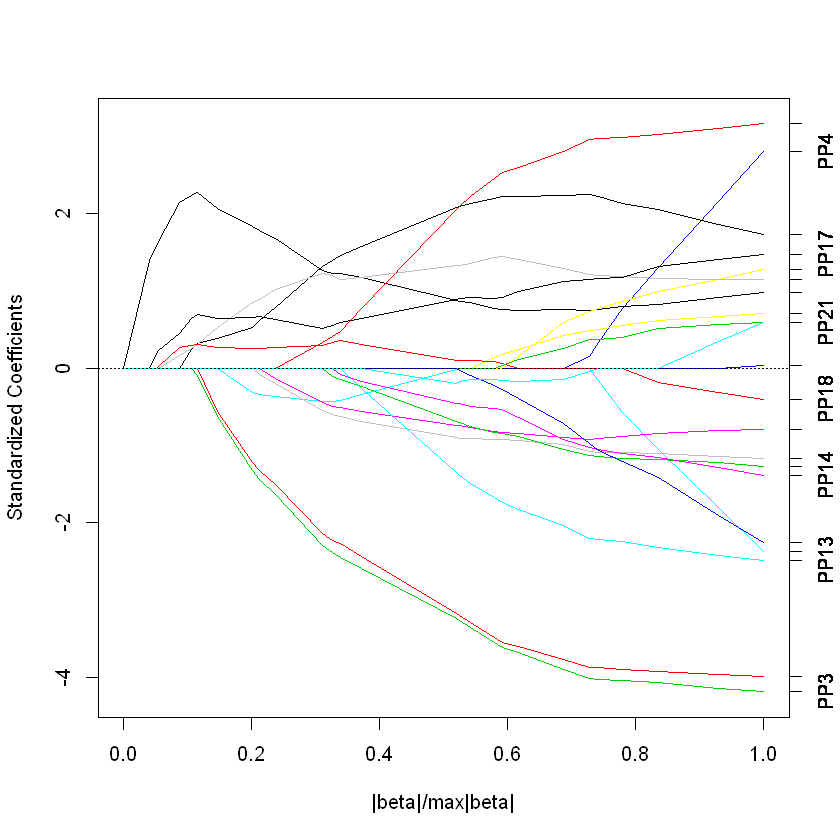

In [31]:
plot(enet$finalModel,use.color =T)
enet.finalCoef<-predict(enet$finalModel,type="coefficients",mode="fraction",s=enet$bestTune$fraction)$coef
enet.finalCoef[order(abs(enet.finalCoef),decreasing = T)]
head(enet.finalCoef[order(abs(enet.finalCoef),decreasing = T)])

通过lasso乃至elastic net等方法的变量选择特点，我们看到了自变量中哪些是重要的，哪些不是。由于所有自变量都是归一化的，这大致可以作为重要性的排序。

### Partial Least Square

In [33]:
pls <- train(x = X, y = y,
             method = "pls",
             tuneLength=10,
             trControl = trControl)
pls

Partial Least Squares 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared 
   1     0.7363147  0.3715763
   2     0.6666783  0.4866863
   3     0.6169916  0.5359418
   4     0.6247479  0.5431368
   5     0.6268527  0.5665616
   6     0.6304428  0.5699974
   7     0.6390508  0.5588724
   8     0.6447784  0.5496344
   9     0.6436157  0.5488394
  10     0.6484118  0.5382332

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was ncomp = 3. 

Comp 1    Comp 2    Comp 3 
31.557602 11.827339  8.964832

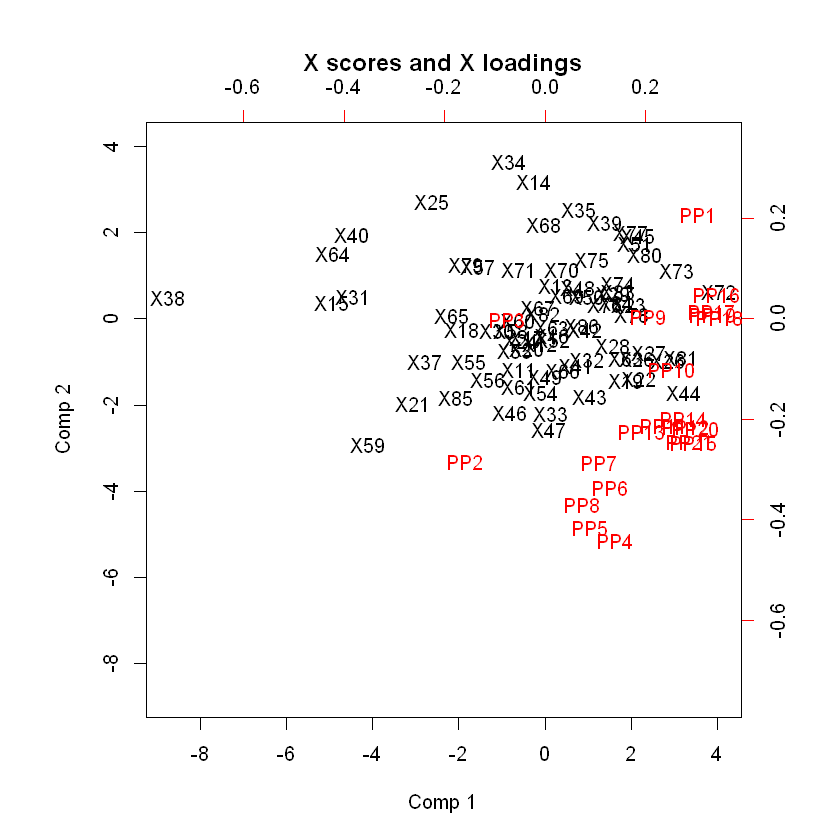

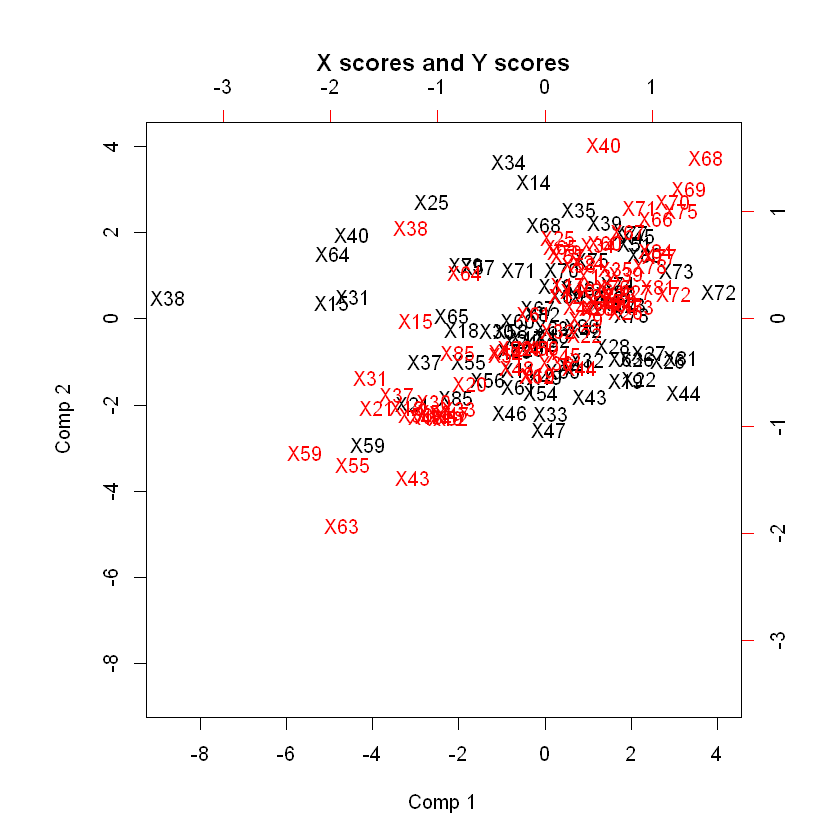

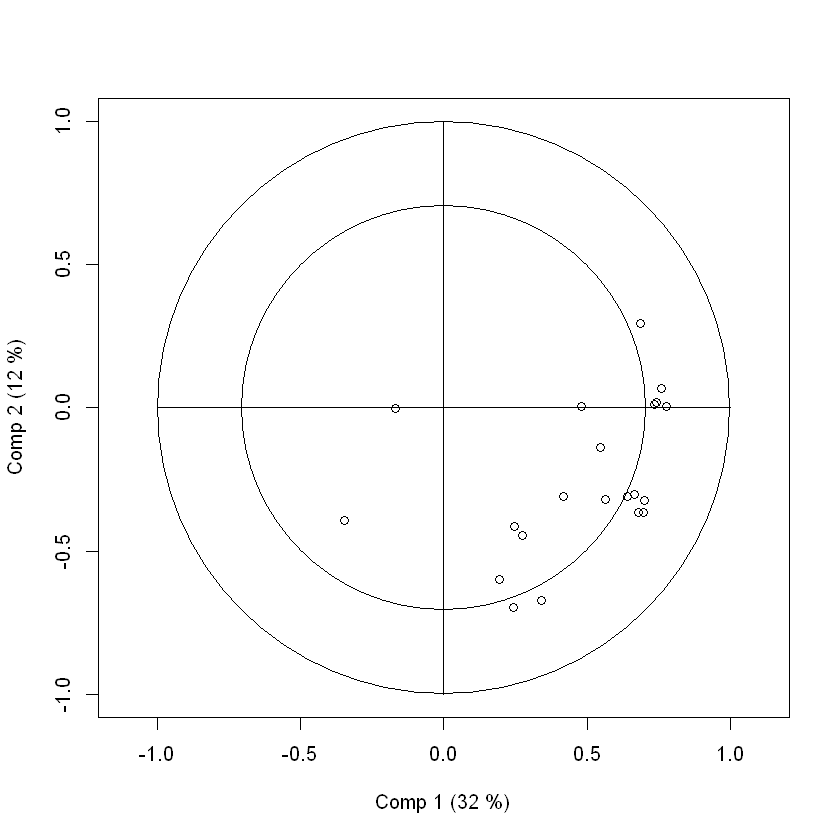

In [34]:
explvar(pls$finalModel)
biplot(pls$finalModel,which="x")
biplot(pls$finalModel,which="scores")
plot(pls$finalModel,plottype="correlation")

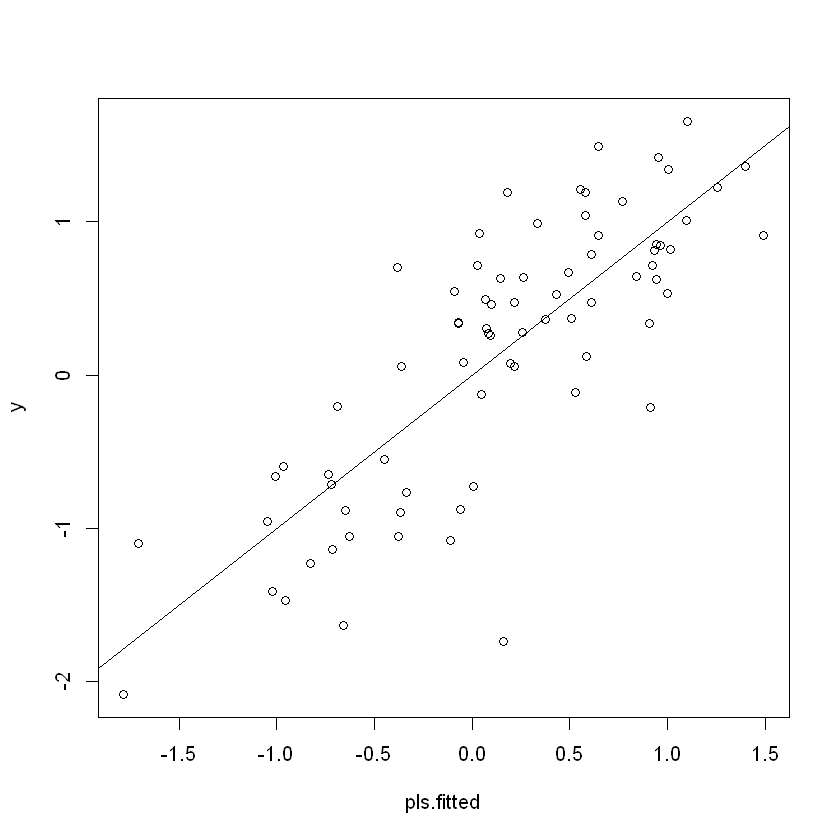

[1] 0.5265257

[1] 0.8033577

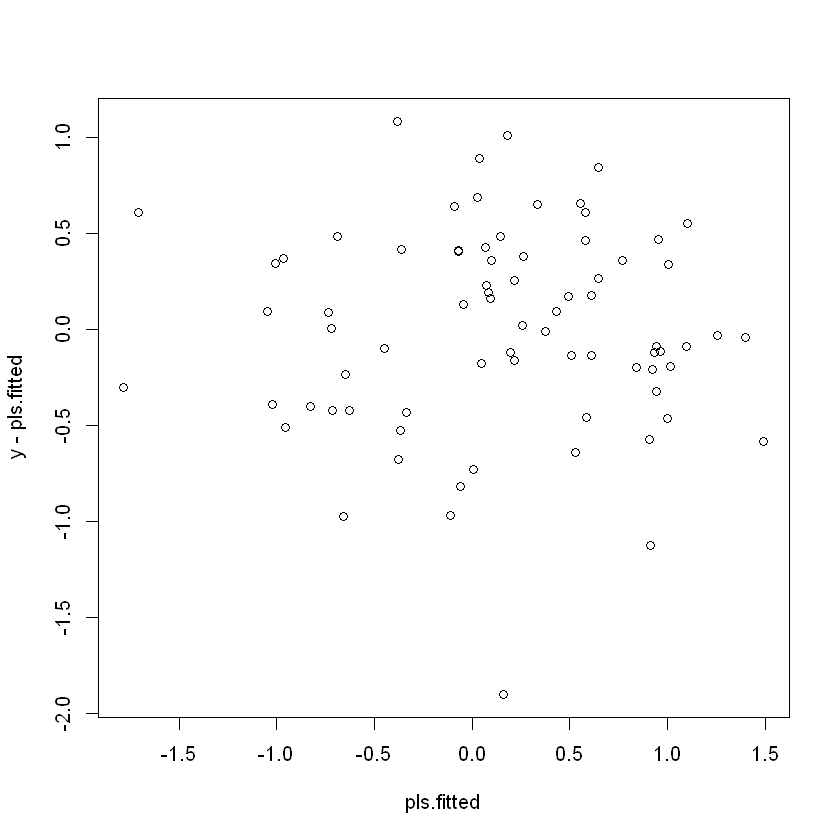

In [35]:
pls.fitted<-predict(pls$finalModel,ncomp=pls$finalModel$ncomp)
plot(pls.fitted,y)
abline(a = 0, b = 1)
plot(pls.fitted,y-pls.fitted)
sqrt(mean((y-pls.fitted)^2))
cor(pls.fitted,y)

### SVM with Linear Kernel

In [37]:
svmLinear <- train(x = X, y = y,
                   method = "svmLinear",
                   #preProcess = "pca",
                   trControl = trControl,
                  tuneGrid=data.frame(C=seq(0.01,0.1,0.01)))
svmLinear

Support Vector Machines with Linear Kernel 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  C     RMSE       Rsquared 
  0.01  0.6393900  0.5485496
  0.02  0.6343082  0.5403752
  0.03  0.6425667  0.5345902
  0.04  0.6349063  0.5535948
  0.05  0.6344177  0.5557623
  0.06  0.6358040  0.5553976
  0.07  0.6392375  0.5572223
  0.08  0.6409081  0.5564324
  0.09  0.6412407  0.5561485
  0.10  0.6434297  0.5528126

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was C = 0.02. 

### SVM with Radial Kernel

In [39]:
set.seed(1)
svmRadial <- train(x = X, y = y,
                   method = "svmRadial",
                   #preProcess = "pca",
                   tuneLength = 10,
                   trControl = trControl)
svmRadial_knn <- train(x = powder.imputed.knn, y = y,
                   method = "svmRadial",
                   #preProcess = "pca",
                   tuneLength = 10,
                   trControl = trControl)
svmRadial_mean <- train(x = powder.imputed.mean, y = y,
                   method = "svmRadial",
                   #preProcess = "pca",
                   tuneLength = 10,
                   trControl = trControl)
svmRadial
#svmRadial_knn
#svmRadial_mean

Support Vector Machines with Radial Basis Function Kernel 

76 samples
21 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  C       RMSE       Rsquared 
    0.25  0.7356658  0.5128335
    0.50  0.6786831  0.5385720
    1.00  0.6231023  0.5792859
    2.00  0.6087199  0.5751504
    4.00  0.6140620  0.5463536
    8.00  0.6263417  0.4956231
   16.00  0.6249902  0.4957795
   32.00  0.6249902  0.4957795
   64.00  0.6249902  0.4957795
  128.00  0.6249902  0.4957795

Tuning parameter 'sigma' was held constant at a value of 0.03078952
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were sigma = 0.03078952 and C = 2. 

In [40]:
svmRadial$finalModel
svmRadial$resample

Support Vector Machine object of class "ksvm" 

SV type: eps-svr  (regression) 
 parameter : epsilon = 0.1  cost C = 2 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.0307895168950236 

Number of Support Vectors : 70 

Objective Function Value : -39.9296 
Training error : 0.136575 

RMSE,Rsquared,Resample
0.6261961,0.4181973,Fold03
0.3618959,0.8773446,Fold02
0.5654572,0.4066675,Fold06
0.5819365,0.4027495,Fold07
0.4926020,0.6360614,Fold01
0.7029894,0.6634662,Fold05
0.5444340,0.7929325,Fold09
0.6320659,0.4246423,Fold10
0.9384870,0.2531872,Fold04
0.6411350,0.8762554,Fold08


## Comparing Models According to 10-fold CV

反映模型评价能力的准则：10-fold CV MSE（或RMSE），认为该值越低的模型预测能力越强。

In [41]:
methods<-list(OLS = OLS, OLS_mean=OLS_mean,OLS_knn=OLS_knn, OLS.restricted=OLS.restricted, 
              lmStepAIC=lmStepAIC,lmStepBIC=lmStepBIC, svmLinear = svmLinear,
                         svmRadial=svmRadial, svmRadial_mean=svmRadial_mean,svmRadial_knn=svmRadial_knn,
                         lasso = lasso,pls = pls,enet=enet,enet_mean=enet_mean,enet_knn=enet_knn
                         )
resamp <- resamples(methods)                     
summary(resamp)$statistics$RMSE
summary(resamp)$statistics$Rsq

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's
OLS,0.4245,0.5606,0.6383,0.6578,0.7554,1.0080,0
OLS_mean,0.4801,0.5416,0.6432,0.6931,0.8325,1.0360,0
OLS_knn,0.4973,0.5362,0.6238,0.6777,0.7807,1.0040,0
OLS.restricted,0.3115,0.4192,0.5976,0.5867,0.7260,0.9356,0
lmStepAIC,0.3949,0.5870,0.6264,0.6476,0.6745,1.0080,0
lmStepBIC,0.3870,0.6013,0.7014,0.6645,0.7308,1.0240,0
svmLinear,0.3933,0.5001,0.6226,0.6343,0.7592,0.9078,0
svmRadial,0.3619,0.5497,0.6041,0.6087,0.6389,0.9385,0
svmRadial_mean,0.3616,0.5962,0.6203,0.6398,0.6694,1.0000,0
svmRadial_knn,0.3651,0.5194,0.6299,0.6199,0.6700,0.9584,0


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's
OLS,0.2299,0.3752,0.5851,0.5342,0.6553,0.7722,0
OLS_mean,0.1882,0.3287,0.4705,0.4669,0.6050,0.7436,0
OLS_knn,0.2257,0.3771,0.5078,0.4894,0.6186,0.7493,0
OLS.restricted,0.2300,0.4518,0.5725,0.5770,0.7548,0.9174,0
lmStepAIC,0.1960,0.3366,0.5907,0.5115,0.6199,0.8051,0
lmStepBIC,0.1768,0.3259,0.5359,0.5038,0.6054,0.8570,0
svmLinear,0.2449,0.3620,0.6086,0.5404,0.6726,0.8298,0
svmRadial,0.2532,0.4095,0.5304,0.5752,0.7606,0.8773,0
svmRadial_mean,0.1393,0.2802,0.4092,0.4651,0.6506,0.8848,0
svmRadial_knn,0.1961,0.3247,0.5313,0.5429,0.7905,0.8821,0


## 对前10个样本的预测

In [42]:
newx<- powder.scaled.test[,predictors.index]
newy<-powder.scaled.test$factor1
sd(newy)
RMSE.record<-c()
yhat.record<-data.frame(id=1:10,ytrue=newy)
yhat.record["OLS"]<-predict(OLS$finalModel,newdata=newx)
yhat.record["OLS_mean"]<-predict(OLS_mean$finalModel,newdata=newx)
yhat.record["OLS_knn"]<-predict(OLS_knn$finalModel,newdata=newx)
yhat.record["OLS.restricted"]<-predict(OLS.restricted$finalModel,newdata=newx)
yhat.record["pls"]<-predict(pls$finalModel,newdata=newx, ncomp = pls$finalModel$ncomp)
yhat.record["lasso"]<-predict(lasso$finalModel,newx=newx,s=lasso$bestTune$fraction,mode="fraction")$fit
yhat.record["enet"]<-predict(enet$finalModel,newx=newx,s=enet$bestTune$fraction,mode="fraction")$fit
yhat.record["svmLinear"]<-predict(svmLinear$finalModel,newdata=newx)
yhat.record["svmRadial"]<-predict(svmRadial$finalModel,newdata=newx)
yhat.record["svmRadial_mean"]<-predict(svmRadial_mean$finalModel,newdata=newx)
yhat.record["svmRadial_knn"]<-predict(svmRadial_knn$finalModel,newdata=newx)

#yhat.record["mean"]<-rowMeans(yhat.record[,-c(1,2)])
for (method in colnames(yhat.record)[-c(1,2)]){
    RMSE.record[method]<-sqrt(mean((yhat.record[method]-newy)^2))
}
yhat.record
RMSE.record[order(RMSE.record)]
# for (method in colnames(yhat.record)[-c(1,2)]){
#     RMSE.record[method]<-sqrt(mean((yhat.record[-8,method]-newy[-8])^2))
# }
# RMSE.record[order(RMSE.record)]

[1] 1.029417

id,ytrue,OLS,OLS_mean,OLS_knn,OLS.restricted,pls,lasso,enet,svmLinear,svmRadial,svmRadial_mean,svmRadial_knn
1,-1.5855122,-1.235586547,-1.2702002,-1.33806520,-1.2735787,-1.26228901,-1.0794214,-1.0855943,-0.7046725,-1.09071624,-0.86657842,-0.91899215
2,-2.3714088,-1.150952322,-1.0650698,-1.11977439,-1.0020097,-1.08654185,-1.0878594,-1.0935166,-0.5961632,-0.94350796,-0.77389403,-0.82734383
3,-0.2747798,0.001373642,0.1986472,0.23418961,0.5773681,0.03459549,0.3132947,0.3164747,0.1466207,0.44972470,0.29989199,0.48048836
4,-1.0845762,-1.090128847,-0.9983714,-1.07490514,-1.9429371,-1.00317991,-0.9603596,-0.9660995,-0.6800874,-0.53279319,-0.38106606,-0.48282601
5,-2.1562664,-2.210344863,-2.1558682,-2.18362914,-2.6699820,-2.14980363,-1.9677296,-1.9784179,-1.5891415,-1.10081480,-0.66854778,-1.00167237
6,-0.9666176,0.003946920,-0.0435570,-0.06115095,-0.5695284,-0.10905434,-0.2429749,-0.2455679,-0.2095178,0.09724259,0.05852838,0.16825398
7,0.4459457,0.577643914,0.6286399,0.76970469,0.7959296,0.71360882,0.7914424,0.7923066,0.5009531,0.32152408,0.17897974,0.31099530
8,-1.5368518,0.411712896,0.5612333,0.55505744,0.2084053,0.60938670,0.6076258,0.6090758,0.3724530,0.03584050,-0.19993435,0.07782884
9,-2.1313065,-0.941475656,-0.9143817,-0.92239325,-0.8548945,-0.59622142,-0.5532731,-0.5574353,-0.3583275,-1.05801435,-0.98076291,-0.97743151
10,0.3943648,0.570936897,0.5388808,0.52756880,1.0405667,0.64252885,0.7463014,0.7421322,0.5510580,0.53640269,0.31294733,0.56056697


OLS        OLS_knn       OLS_mean      svmRadial OLS.restricted 
     0.8884986      0.9310048      0.9395040      0.9497286      0.9524860 
           pls           enet          lasso svmRadial_mean  svmRadial_knn 
     0.9843376      1.0060354      1.0077844      1.0172179      1.0181550 
     svmLinear 
     1.0945261

## 考虑平方项或交互项
自变量总共有21个，如果考虑平方项则又有21个，如果考虑交互项则有$\left(\begin{array}{c}21\\2\end{array}\right)=210$个，甚至已经超出了样本得个数（$n=86$），这就要求只考虑有显著影响的变量。
（注：之后一律采用标准化、`impute.knn`的数据）

In [43]:
powder.augmented<-powder[,predictors.index]
for (PP in (paste("PP",1:21,sep=""))){
    powder.augmented[paste(PP,"_sqrd",sep = "")]<-powder[PP]^2
}
# head(powder.augmented)
# colnames(powder.augmented)

In [44]:
predictors.sqrt.index<-grep("PP\\d+[_]sqrd", colnames(powder.augmented),value=T)
#powder.augmented[,predictors.sqrt.index]<-scale(powder.augmented[,predictors.sqrt.index])
#head(powder.augmented[,predictors.sqrt.index])

In [45]:
combni<-combn(1:21,2)
for (i in (1:ncol(combni))){
    powder.augmented[paste("PP_",combni[1,i],"_",combni[2,i],sep = "")]<-powder[,combni[1,i]]*powder[,combni[2,i]]
}
#head(powder.augmented)
#colnames(powder.augmented);ncol(powder.augmented)

In [46]:
predictors.ia.index<-grep("PP[_]", colnames(powder.augmented),value=T) #交互项index
predictors.tot.index<-c(predictors.index,predictors.sqrt.index,predictors.ia.index) # 所有自变量的index

在加入了这些新的变量之后，仍然采用knn填补

In [47]:
powder.augmented.imputed.knn <-scale(powder.augmented)
powder.augmented.imputed.knn[,predictors.index]<-t(impute::impute.knn(t(powder.augmented.imputed.knn[,predictors.index]))[['data']])
powder.augmented.imputed.knn<-t(impute::impute.knn(t(powder.augmented.imputed.knn))[['data']])

## 仍然分训练集和测试集
前10个样本为测试集，其余为训练集。

In [48]:
X.aug<-powder.augmented.imputed.knn.train<-powder.augmented.imputed.knn[-(1:10),]
powder.augmented.imputed.knn.test<-powder.augmented.imputed.knn[1:10,]
#head(X.aug)
ncol(X.aug)

[1] 252

In [49]:
head(colnames(X.aug)[order(abs(cor(X.aug,y)),decreasing = T)],20)
head(cor(X.aug,y)[order(abs(cor(X.aug,y)),decreasing = T)],20)

[1] "PP_2_17"  "PP_2_18"  "PP_2_19"  "PP_2_20"  "PP_2_11"  "PP_2_13" 
 [7] "PP_2_21"  "PP_2_16"  "PP1"      "PP_2_12"  "PP_2_15"  "PP_2_14" 
[13] "PP_2_8"   "PP_1_2"   "PP1_sqrd" "PP_2_7"   "PP_2_10"  "PP_18_20"
[19] "PP_17_18" "PP_1_10"

[1] 0.5919141 0.5904940 0.5881020 0.5807187 0.5748235 0.5712343 0.5660344
 [8] 0.5651398 0.5635167 0.5596128 0.5554740 0.5492827 0.5440214 0.5349242
[15] 0.5247686 0.5241539 0.5231991 0.4890318 0.4763512 0.4736520

### Stepwise Regression

In [50]:
lmStepBIC.aug <- train(x = X.aug[,c(grep("PP[_]2",colnames(X.aug),value = T),predictors.index)],
                       y = y,
                       method = "lmStepAIC",trace=F,k=log(nrow(X.aug)),
                       #preProcess = "pca",
                       trControl = trControl)
lmStepBIC.aug
summary(lmStepBIC.aug$finalModel)

Linear Regression with Stepwise Selection 

76 samples
41 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared 
  0.8183479  0.3905227

 


Call:
lm(formula = .outcome ~ PP_2_4 + PP_2_5 + PP_2_6 + PP_2_8 + PP_2_11 + 
    PP_2_12 + PP_2_14 + PP_2_15 + PP_2_16 + PP_2_17 + PP_2_19 + 
    PP_2_20 + PP_20_21 + PP2 + PP4 + PP5 + PP11 + PP13 + PP14 + 
    PP16 + PP18 + PP19, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22866 -0.25288  0.03902  0.21697  0.85571 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.05896    0.06261  -0.942 0.350654    
PP_2_4       -0.73082    0.10091  -7.242 1.84e-09 ***
PP_2_5       -2.84844    1.19505  -2.384 0.020762 *  
PP_2_6        2.95227    1.36970   2.155 0.035691 *  
PP_2_8        0.75014    0.33382   2.247 0.028819 *  
PP_2_11       2.82678    0.76313   3.704 0.000507 ***
PP_2_12     -22.61118    5.29503  -4.270 8.13e-05 ***
PP_2_14       5.34036    2.44808   2.181 0.033607 *  
PP_2_15      11.45102    4.31590   2.653 0.010498 *  
PP_2_16       2.96623    1.15983   2.557 0.013441 *  
PP_2_17      -7.94470    2.71796  -2.923 0.

似乎在加入了更多的自变量（平方项）后，逐步回归的效果反而变差了。（RMSE不降反增）。

### Partial Least Square

In [51]:
pls.aug <- train(x = X.aug,
    #x = powder.augmented.imputed.knn[,predictors.index],
                 y = y,
                 method = "pls",
                 #preProcess = "pca",
                 tuneLength=10,
                 trControl = trControl)
pls.aug

Partial Least Squares 

 76 samples
252 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared 
   1     0.7049500  0.4168898
   2     0.5882099  0.5892351
   3     0.5488371  0.6390946
   4     0.5494725  0.6525460
   5     0.5601271  0.6330738
   6     0.5537498  0.6378837
   7     0.5636878  0.6379009
   8     0.5662743  0.6247688
   9     0.5779131  0.6032797
  10     0.5886000  0.5865689

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was ncomp = 3. 

In [52]:
summary(pls.aug$finalModel)
class(pls.aug$finalModel)
pls.aug$finalModel$loadings
pls.aug$finalModel$loading.weights
pls.aug$finalModel$projection

Data: 	X dimension: 76 252 
	Y dimension: 76 1
Fit method: oscorespls
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X           30.96    44.28    55.37
.outcome    40.72    63.11    67.66


[1] "mvr"


Loadings:
          Comp 1 Comp 2 Comp 3
PP1        0.103              
PP2                      0.160
PP3                     -0.206
PP4              -0.102       
PP5                           
PP6              -0.107       
PP7                           
PP8              -0.104       
PP9                           
PP10                          
PP11                          
PP12                          
PP13                          
PP14                          
PP15                          
PP16                          
PP17                          
PP18                          
PP19                          
PP20                          
PP21                          
PP1_sqrd                      
PP2_sqrd                -0.118
PP3_sqrd                -0.201
PP4_sqrd                      
PP5_sqrd                      
PP6_sqrd         -0.109       
PP7_sqrd                      
PP8_sqrd         -0.104       
PP9_sqrd                      
PP10_sqrd                   


Loadings:
          Comp 1 Comp 2 Comp 3
PP1        0.119              
PP2                           
PP3                     -0.123
PP4                           
PP5                           
PP6                           
PP7                           
PP8                           
PP9                           
PP10                          
PP11                    -0.127
PP12                          
PP13                          
PP14                    -0.122
PP15                          
PP16                          
PP17                          
PP18                          
PP19                          
PP20                          
PP21                          
PP1_sqrd   0.110              
PP2_sqrd                -0.185
PP3_sqrd                -0.124
PP4_sqrd                      
PP5_sqrd                      
PP6_sqrd                      
PP7_sqrd                      
PP8_sqrd                      
PP9_sqrd                      
PP10_sqrd                   

,Comp 1,Comp 2,Comp 3
PP1,0.118759210,0.09149002,-0.035766133
PP2,-0.072409509,-0.09061438,0.042277453
PP3,-0.055474404,-0.08005158,-0.150769805
PP4,0.009646413,-0.07518959,0.036989695
PP5,-0.010200806,-0.09426079,-0.002032959
PP6,-0.006936449,-0.09444220,0.013558782
PP7,0.006389051,-0.05483053,0.034255844
PP8,-0.017556883,-0.09944592,0.004456789
PP9,0.082713952,0.06096664,0.090159742
PP10,0.059825142,0.01285354,0.067609998


Comp 1   Comp 2   Comp 3 
30.95542 13.32776 11.08892

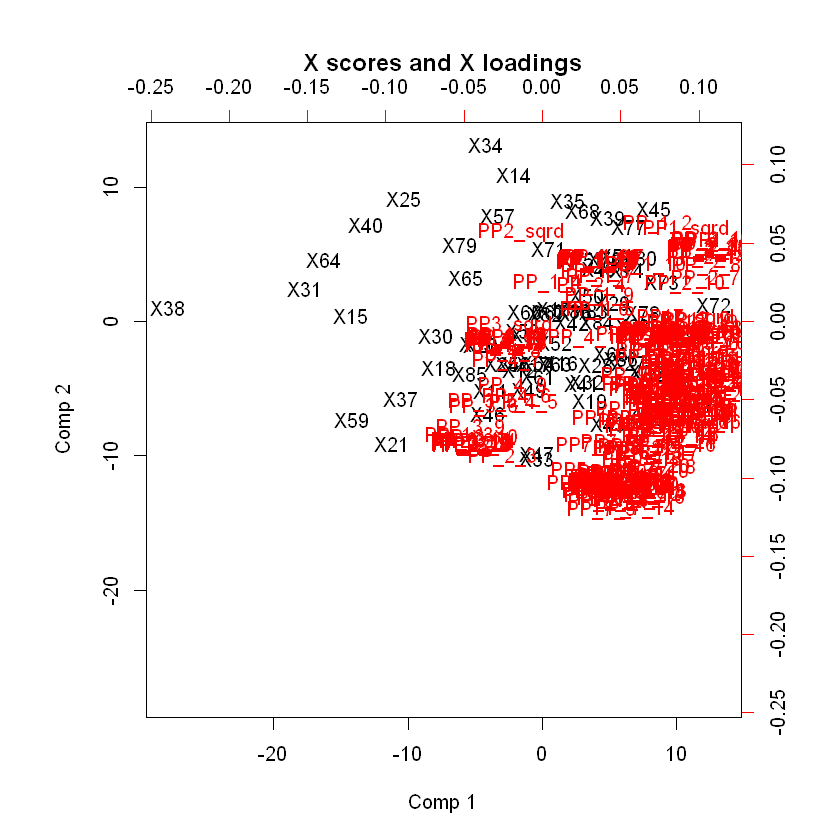

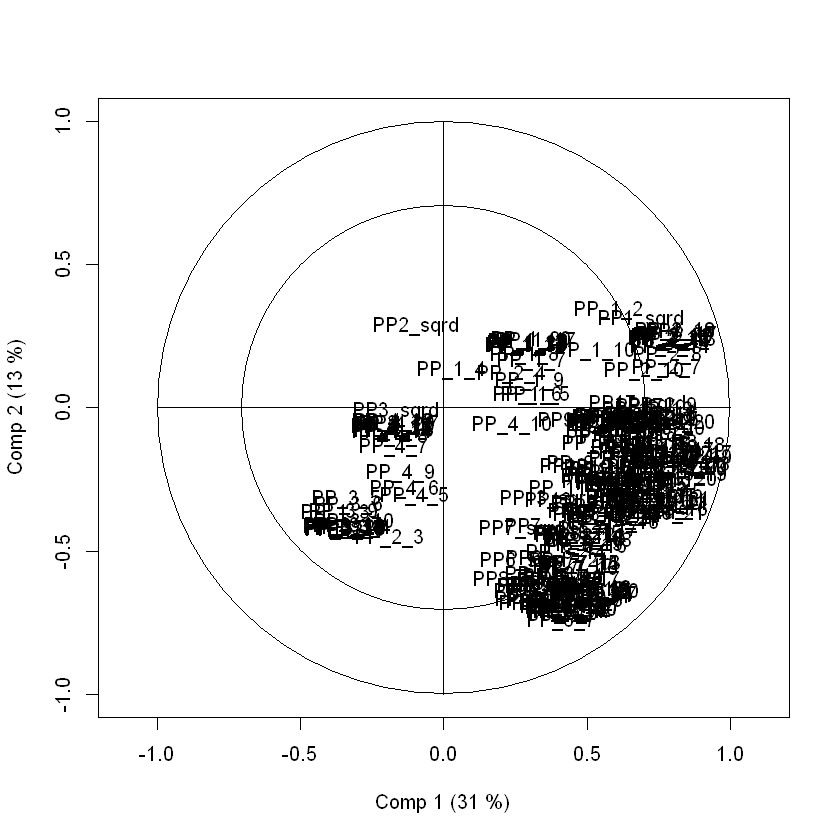

In [53]:
explvar(pls.aug$finalModel)
biplot(pls.aug$finalModel,which="x")
#coef(pls.aug.finalModel)  # 252个
corrplot(pls.aug$finalModel,labels=colnames(X.aug))

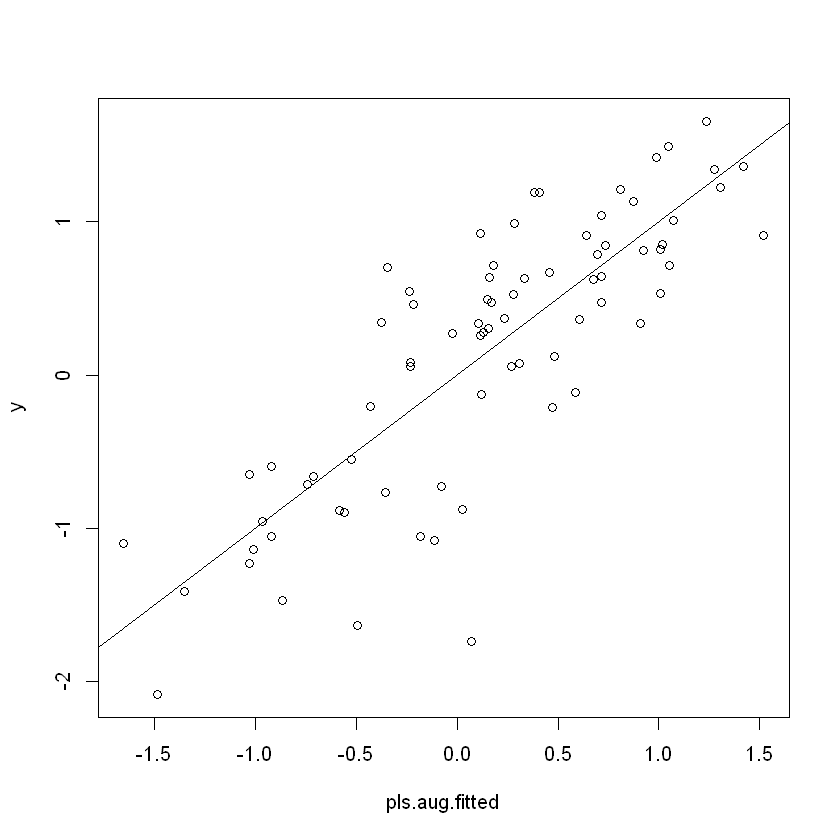

[1] 0.5027787

[1] 0.8225872

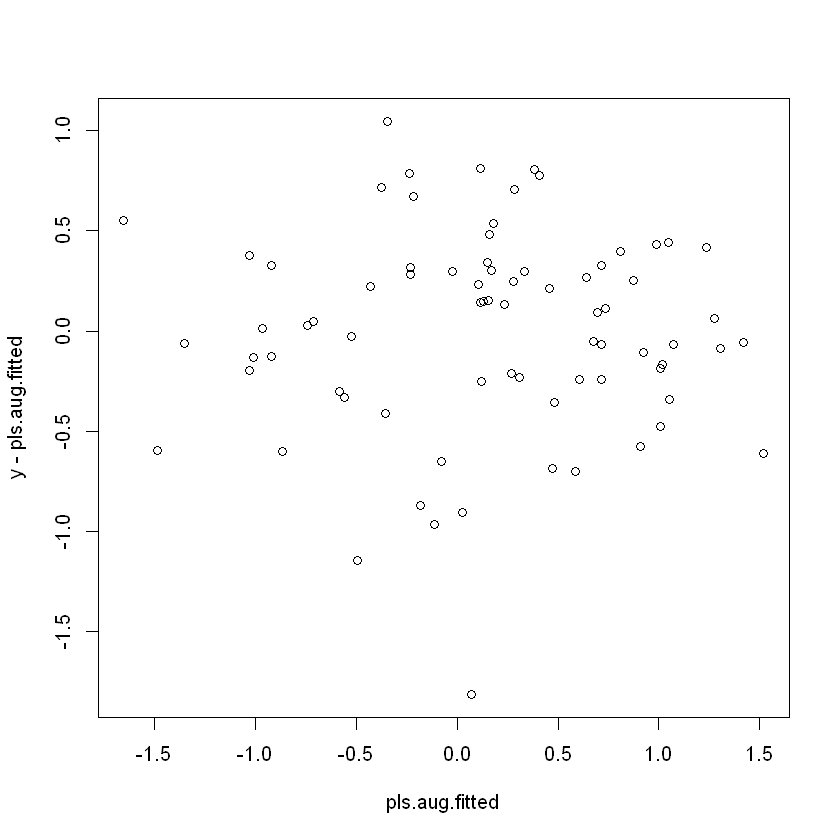

In [54]:
pls.aug.fitted<-predict(pls.aug$finalModel,ncomp=pls.aug$bestTune$ncomp)
plot(pls.aug.fitted,y)
abline(a = 0, b = 1)
plot(pls.aug.fitted,y-pls.aug.fitted)
sqrt(mean((y-pls.aug.fitted)^2))
cor(pls.aug.fitted,y)

In [56]:
pls.aug.finalCoef<-coef(pls.aug$finalModel, ncomp=pls.aug$bestTune$ncomp)
summary(pls.aug$finalModel)
#pls.aug$finalModel$xNames[order(abs(pls.aug.finalCoef),decreasing = T)]
#pls.aug.finalCoef[order(abs(pls.aug.finalCoef),decreasing = T)]

Data: 	X dimension: 76 252 
	Y dimension: 76 1
Fit method: oscorespls
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X           30.96    44.28    55.37
.outcome    40.72    63.11    67.66


### Lasso

In [57]:
lasso.aug <- train(x =X.aug, y = y,
               method = "lasso",
               #preProcess = "pca",
               tuneGrid=data.frame(fraction=seq(0.01,0.1,0.01)),
               trControl = trControl)
lasso.aug

The lasso 

 76 samples
252 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  fraction  RMSE       Rsquared 
  0.01      0.6513141  0.4614004
  0.02      0.5845682  0.5818238
  0.03      0.5759930  0.6128123
  0.04      0.5921489  0.6010864
  0.05      0.6144012  0.5753466
  0.06      0.6515288  0.5276755
  0.07      0.6808084  0.4896541
  0.08      0.7055652  0.4631316
  0.09      0.7293999  0.4361376
  0.10      0.7448612  0.4196183

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was fraction = 0.03. 

[1] 0.03

PP_3_8     PP_4_15      PP_1_2    PP_11_17     PP_8_10    PP_12_15 
-0.44023485 -0.28376913  0.24968469  0.19620788  0.16967805 -0.16099949 
   PP_11_16    PP9_sqrd     PP_9_14     PP_1_17      PP_1_6    PP2_sqrd 
 0.15586433  0.15071264 -0.14728657  0.14102627 -0.11668563 -0.11039962 
     PP_2_4    PP5_sqrd    PP_14_21        PP14    PP_11_18    PP_16_17 
-0.10834820 -0.10772868 -0.09086357 -0.07802574  0.07548884  0.07049916 
    PP_7_13     PP_8_17      PP_2_5    PP_12_21      PP_1_3 
-0.05826231  0.04854117  0.03129926 -0.02448546 -0.02374430

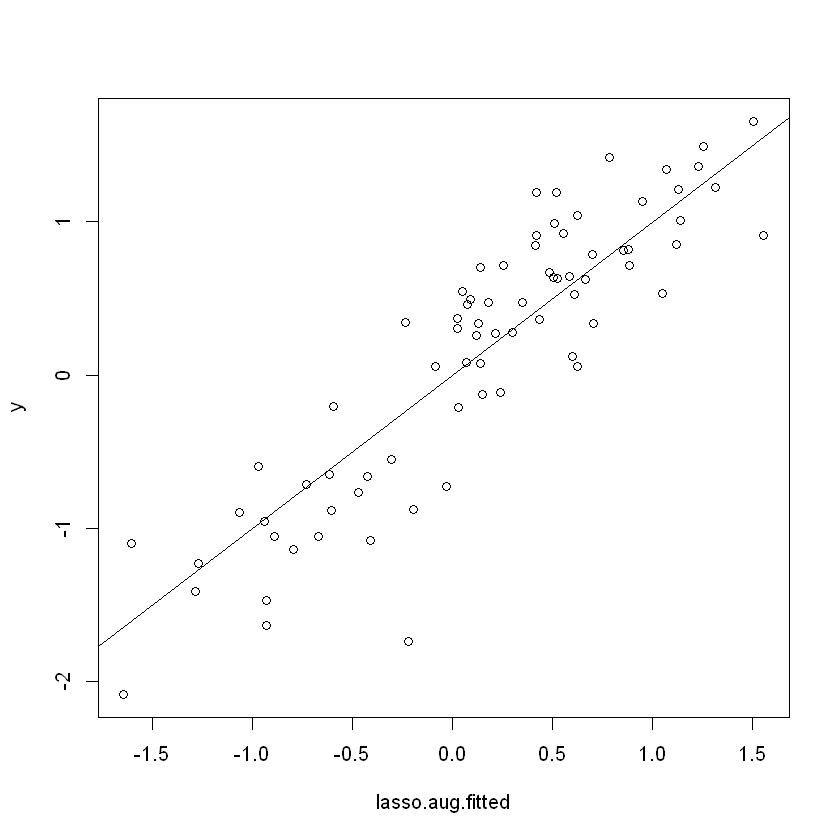

[1] 0.399643

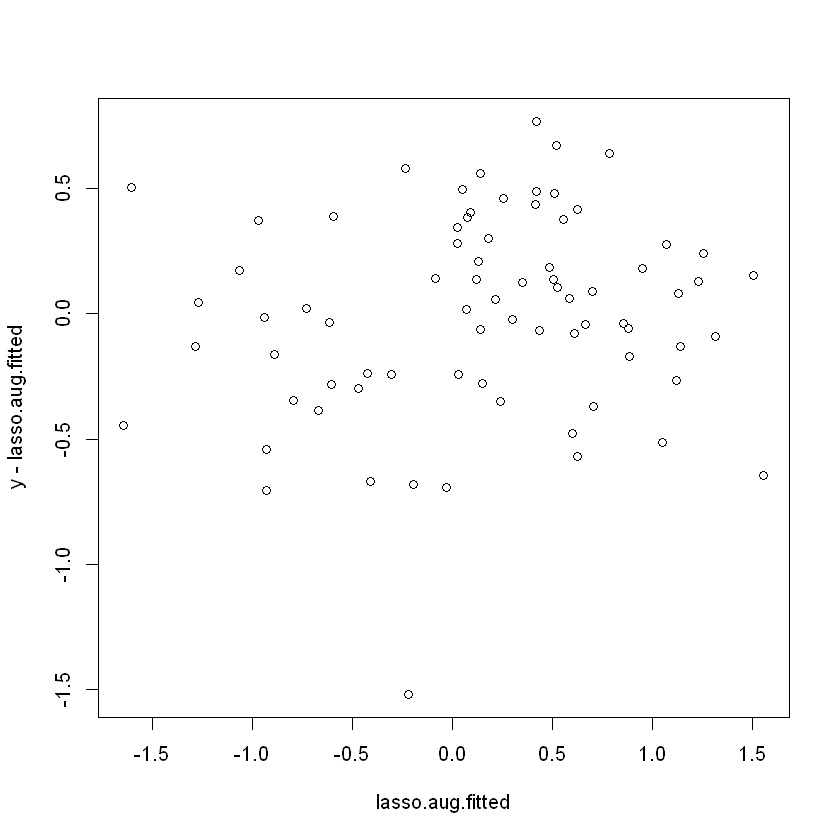

In [58]:
#根据我们bestTune的参数lambda
lasso.aug$bestTune$fraction
lasso.aug.finalCoef<-predict(lasso.aug$finalModel,type="coefficients",mode="fraction",s=lasso.aug$bestTune$fraction)$coef
lasso.aug.finalCoef.nonzero<-lasso.aug.finalCoef[which(lasso.aug.finalCoef!=0)]
lasso.aug.finalCoef.nonzero[order(abs(lasso.aug.finalCoef.nonzero),decreasing = T)]
lasso.aug.fitted<-predict(lasso.aug$finalModel,mode="fraction",s=lasso.aug$bestTune$fraction,newx=X.aug)$fit
plot(lasso.aug.fitted,y)
abline(a = 0, b = 1)
plot(lasso.aug.fitted,y-lasso.aug.fitted) # 残差依然和y高度相关
sqrt(mean((y-lasso.aug.fitted)^2))

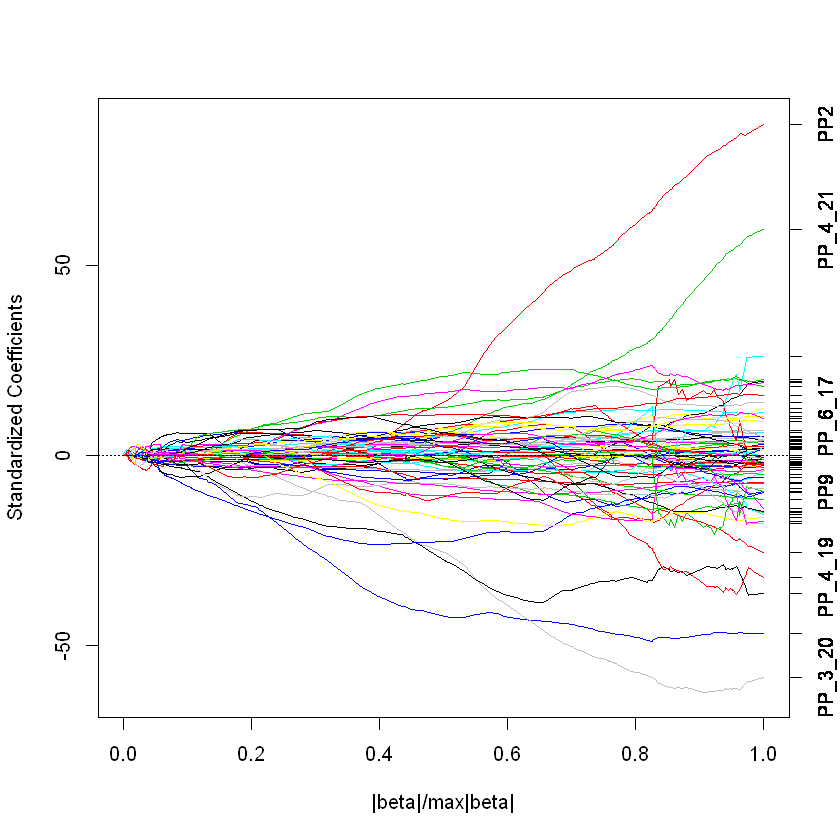

In [59]:
plot(lasso.aug$finalModel,use.color =T)

### SVM with Linear Kernel

In [60]:
set.seed(1)
svmLinear.aug <- train(x=X.aug,y=y,
    #x = X.aug[,names(lasso.aug.finalCoef.nonzero)], y = y,
    
                       method = "svmLinear",
                       #preProcess = "pca",
                       tuneGrid=data.frame(C=seq(0.01,0.1,0.01)),
                       trControl = trControl)
svmLinear.aug

Support Vector Machines with Linear Kernel 

 76 samples
252 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  C     RMSE       Rsquared 
  0.01  0.5449292  0.6697547
  0.02  0.5440998  0.6668167
  0.03  0.5520797  0.6555191
  0.04  0.5577137  0.6487326
  0.05  0.5671280  0.6361169
  0.06  0.5768440  0.6206023
  0.07  0.5852009  0.6083794
  0.08  0.5948885  0.5953382
  0.09  0.6023343  0.5865995
  0.10  0.6072084  0.5793817

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was C = 0.02. 

### SVM with Radial Kernel

In [61]:
set.seed(1)
svmRadial.aug <- train(x = X.aug, y = y,
                       method = "svmRadial",
                       #preProcess = "pca",
                       tuneLength = 10,
                       trControl = trControl)
svmRadial.aug

Support Vector Machines with Radial Basis Function Kernel 

 76 samples
252 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results across tuning parameters:

  C       RMSE       Rsquared 
    0.25  0.7098923  0.5744243
    0.50  0.6168695  0.5974411
    1.00  0.5658658  0.6304510
    2.00  0.5721891  0.6081474
    4.00  0.5705370  0.5771910
    8.00  0.5838142  0.5401925
   16.00  0.5859070  0.5391797
   32.00  0.5859070  0.5391797
   64.00  0.5859070  0.5391797
  128.00  0.5859070  0.5391797

Tuning parameter 'sigma' was held constant at a value of 0.003132951
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were sigma = 0.003132951 and C = 1. 

可以看到，加入线性项之后，之前表现最好的SVM with Radial Kernel的方法预测效果也有不小的提升。

In [62]:
OLS.aug <- train(x = X.aug[,head(names(lasso.aug.finalCoef.nonzero),10)], y = y,
                       method = "lm",
                       #preProcess = "pca",
                       tuneLength = 10,
                       trControl = trControl)
OLS.aug

Linear Regression 

76 samples
10 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 68, 69, 68, 68, 68, ... 
Resampling results:

  RMSE       Rsquared 
  0.5751537  0.5757133

Tuning parameter 'intercept' was held constant at a value of TRUE
 

# 模型总结
## 污渍1 `powdow.scaled['factor1']`

### 重要自变量
注：认为lasso回归中系数较大的自变量为对响应变量有显著的。

In [63]:
lasso.aug.finalCoef.nonzero<-lasso.aug.finalCoef[which(lasso.aug.finalCoef!=0)]
lasso.aug.finalCoef.nonzero[order(abs(lasso.aug.finalCoef.nonzero),decreasing = T)]
names(lasso.aug.finalCoef.nonzero)

PP_3_8     PP_4_15      PP_1_2    PP_11_17     PP_8_10    PP_12_15 
-0.44023485 -0.28376913  0.24968469  0.19620788  0.16967805 -0.16099949 
   PP_11_16    PP9_sqrd     PP_9_14     PP_1_17      PP_1_6    PP2_sqrd 
 0.15586433  0.15071264 -0.14728657  0.14102627 -0.11668563 -0.11039962 
     PP_2_4    PP5_sqrd    PP_14_21        PP14    PP_11_18    PP_16_17 
-0.10834820 -0.10772868 -0.09086357 -0.07802574  0.07548884  0.07049916 
    PP_7_13     PP_8_17      PP_2_5    PP_12_21      PP_1_3 
-0.05826231  0.04854117  0.03129926 -0.02448546 -0.02374430

[1] "PP14"     "PP2_sqrd" "PP5_sqrd" "PP9_sqrd" "PP_1_2"   "PP_1_3"  
 [7] "PP_1_6"   "PP_1_17"  "PP_2_4"   "PP_2_5"   "PP_3_8"   "PP_4_15" 
[13] "PP_7_13"  "PP_8_10"  "PP_8_17"  "PP_9_14"  "PP_11_16" "PP_11_17"
[19] "PP_11_18" "PP_12_15" "PP_12_21" "PP_14_21" "PP_16_17"

### 预测
#### 10-fold CV

In [64]:
methods<-list(OLS = OLS, OLS.restricted=OLS.restricted, lmStepAIC=lmStepAIC, svmLinear = svmLinear,
                         svmRadial=svmRadial,
                         lasso = lasso, pls = pls,enet=enet,
                         svmRadial.aug=svmRadial.aug,svmLinear.aug=svmLinear.aug,
                         lasso.aug=lasso.aug, pls.aug=pls.aug)
resamp <- resamples(methods)                     
summary(resamp)$statistics$RMSE

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's
OLS,0.4245,0.5606,0.6383,0.6578,0.7554,1.0080,0
OLS.restricted,0.3115,0.4192,0.5976,0.5867,0.7260,0.9356,0
lmStepAIC,0.3949,0.5870,0.6264,0.6476,0.6745,1.0080,0
svmLinear,0.3933,0.5001,0.6226,0.6343,0.7592,0.9078,0
svmRadial,0.3619,0.5497,0.6041,0.6087,0.6389,0.9385,0
lasso,0.3790,0.5219,0.6052,0.6118,0.6986,0.9280,0
pls,0.3513,0.5131,0.5623,0.6170,0.7319,0.9749,0
enet,0.3796,0.5222,0.6036,0.6115,0.6987,0.9296,0
svmRadial.aug,0.3639,0.4644,0.5752,0.5659,0.6453,0.8672,0
svmLinear.aug,0.3758,0.4061,0.5215,0.5441,0.6397,0.8623,0


#### 对前10个样本的预测

In [65]:
newx<- powder.scaled.test[,predictors.index]
newy<-powder.scaled.test$factor1
RMSE.record<-c()
yhat.record<-data.frame(id=1:10,ytrue=newy)
yhat.record["OLS"]<-predict(OLS$finalModel,newdata=newx)
yhat.record["pls"]<-predict(pls$finalModel,newdata=newx, ncomp = pls$finalModel$ncomp)
yhat.record["pls.aug"]<-predict(pls.aug$finalModel,newdata=powder.augmented.imputed.knn.test, ncomp = pls.aug$finalModel$ncomp)
yhat.record["lasso"]<-predict(lasso$finalModel,newx=newx,s=lasso$bestTune$fraction,mode="fraction")$fit
yhat.record["lasso.aug"]<-predict(lasso.aug$finalModel,newx=powder.augmented.imputed.knn.test,s=lasso.aug$bestTune$fraction,mode="fraction")$fit
yhat.record["enet"]<-predict(enet$finalModel,newx=newx,s=enet$bestTune$fraction,mode="fraction")$fit
yhat.record["svmLinear"]<-predict(svmLinear$finalModel,newdata=newx)
yhat.record["svmLinear.aug"]<-predict(svmLinear.aug$finalModel,newdata=powder.augmented.imputed.knn.test)
yhat.record["svmRadial"]<-predict(svmRadial$finalModel,newdata=newx)
yhat.record["svmRadial.aug"]<-predict(svmRadial.aug$finalModel,newdata=powder.augmented.imputed.knn.test)

#yhat.record["mean"]<-rowMeans(yhat.record[,-c(1,2)])
for (method in colnames(yhat.record)[-c(1,2)]){
    RMSE.record[method]<-sqrt(mean((yhat.record[method]-newy)^2))
}
yhat.record
RMSE.record[order(RMSE.record)]

# for (method in colnames(yhat.record)[-c(1,2)]){
#     RMSE.record[method]<-sqrt(mean((yhat.record[-8,method]-newy[-8])^2))
# }
# RMSE.record[order(RMSE.record)]

id,ytrue,OLS,pls,pls.aug,lasso,lasso.aug,enet,svmLinear,svmLinear.aug,svmRadial,svmRadial.aug
1,-1.5855122,-1.235586547,-1.26228901,-1.5898191,-1.0794214,-1.65089485,-1.0855943,-0.7046725,-1.73474293,-1.09071624,-0.78368548
2,-2.3714088,-1.150952322,-1.08654185,-1.5856431,-1.0878594,-1.31247786,-1.0935166,-0.5961632,-1.38487626,-0.94350796,-1.07801483
3,-0.2747798,0.001373642,0.03459549,-0.4910662,0.3132947,0.24028108,0.3164747,0.1466207,-0.13518253,0.44972470,0.16250107
4,-1.0845762,-1.090128847,-1.00317991,-1.3115291,-0.9603596,-1.19699602,-0.9660995,-0.6800874,-1.44070819,-0.53279319,-0.52732721
5,-2.1562664,-2.210344863,-2.14980363,-2.5096955,-1.9677296,-2.01033885,-1.9784179,-1.5891415,-2.75956045,-1.10081480,-0.76743581
6,-0.9666176,0.003946920,-0.10905434,-0.1984712,-0.2429749,-0.15351906,-0.2455679,-0.2095178,-0.05311603,0.09724259,-0.07981223
7,0.4459457,0.577643914,0.71360882,0.3512938,0.7914424,0.47569562,0.7923066,0.5009531,0.49920565,0.32152408,0.25383973
8,-1.5368518,0.411712896,0.60938670,0.2226336,0.6076258,0.38929570,0.6090758,0.3724530,0.26735330,0.03584050,0.11835985
9,-2.1313065,-0.941475656,-0.59622142,-0.9975191,-0.5532731,-1.12587152,-0.5574353,-0.3583275,-1.35485482,-1.05801435,-0.85970426
10,0.3943648,0.570936897,0.64252885,0.3890659,0.7463014,0.03921184,0.7421322,0.5510580,-0.01244875,0.53640269,0.33144626


pls.aug svmLinear.aug     lasso.aug           OLS     svmRadial 
    0.7629511     0.7979129     0.8327017     0.8884986     0.9497286 
          pls svmRadial.aug          enet         lasso     svmLinear 
    0.9843376     0.9965124     1.0060354     1.0077844     1.0945261

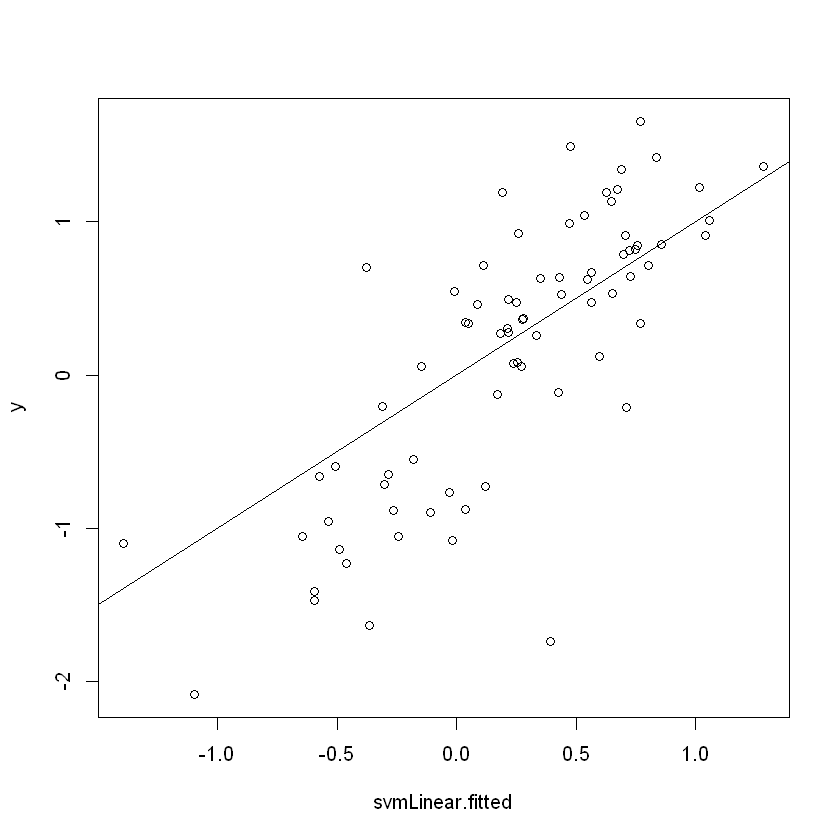

[1] 0.5751663

[1] 0.7914326

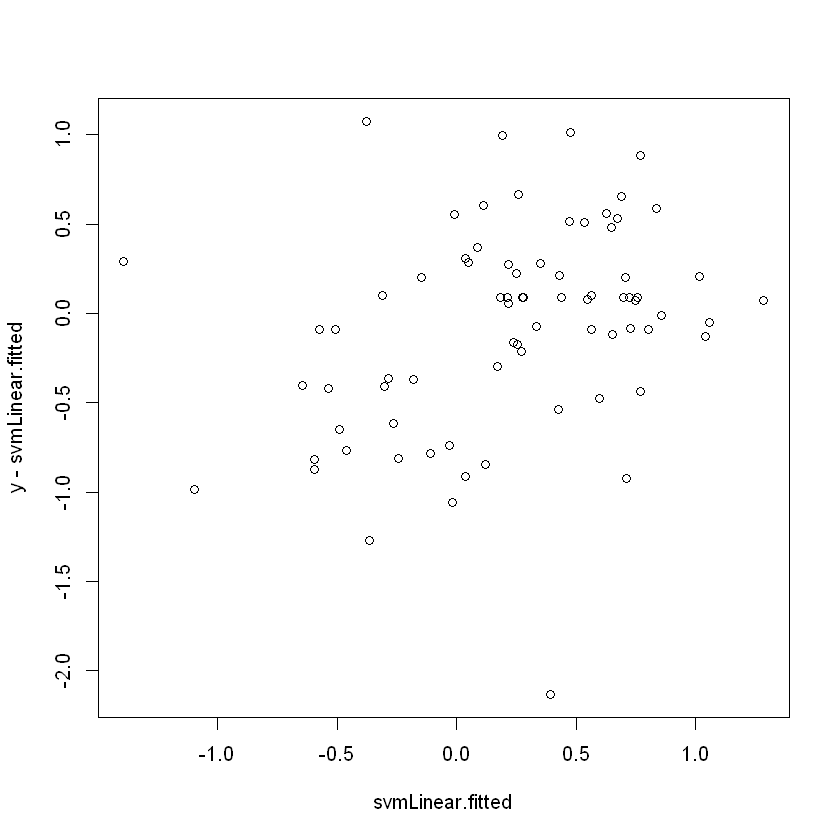

In [66]:
svmLinear.fitted<-predict(svmLinear,X)
plot(svmLinear.fitted,y)
abline(a = 0, b = 1)
plot(svmLinear.fitted,y-svmLinear.fitted)
sqrt(mean((y-svmLinear.fitted)^2))
cor(svmLinear.fitted,y)